
# Descargar y análisis de artículos en Wikipedia

Este programa descarga todos los últimos artículos de Wikipedia y luego se analizarán. Se utilizarán unas series de técnicas importantes de ciencia de datos que incluyen:

* Encontrar y recuperar datos en línea

Las técnicas cubiertas aquí son ampliamente aplicables en ciencia de datos a pesar de que nos estamos centrando en los artículos de Wikipedia.  Wikipedia es una fuente increíblemente rica de información creada y actualizada por personas, aprender a trabajar con ella es un proyecto en sí mismo y también nos brinda más datos para futuros proyectos de ciencia de datos.

El código en este cuaderno está adaptado del excelente [Deep Learning Cookbook](http://shop.oreilly.com/product/0636920097471.do) de Douwe Osinga. El libro merece la pena y puede acceder a los Cuadernos Jupyter [en GitHub](https://github.com/DOsinga/deep_learning_cookbook).

In [1]:
import requests

# Parsing HTML
from bs4 import BeautifulSoup

# File system management
import os

## Descargar última versión Wikipedia

Para comenzar, se realiza una solicitud a [Wikimedia dumps](https://dumps.wikimedia.org/) de Wikipedia. Buscará a través de `enwiki` que tiene los [English language dumps](https://dumps.wikimedia.org/enwiki/) de wikipedia. Esta primera solicitud encuentra los volcados más recientes disponibles y los enumera. (Un volcado es una instantánea de toda la información existente de una base de datos).

In [2]:
base_url = 'https://dumps.wikimedia.org/enwiki/'
index = requests.get(base_url).text
soup_index = BeautifulSoup(index, 'html.parser')

# Find the links that are dates of dumps
dumps = [a['href'] for a in soup_index.find_all('a') if 
         a.has_attr('href')]
dumps

['../',
 '20200220/',
 '20200301/',
 '20200401/',
 '20200420/',
 '20200501/',
 '20200520/',
 '20200601/',
 'latest/']

En el siguiente código se encuentra el contenido html de la página dump.

In [3]:
dump_url = base_url + 'latest/'

# Retrieve the html
dump_html = requests.get(dump_url).text
dump_html[:100]

'<html>\r\n<head><title>Index of /enwiki/latest/</title></head>\r\n<body bgcolor="white">\r\n<h1>Index of /'

Una dirección de ejemplo de las descargas disponibles a https://dumps.wikimedia.org/enwiki/20180901/.

### Decidir qué descargar

Se descargará la versión más reciente de los propios artículos. Es posible obtener la historia pasada de los artículos, las ediciones, la discusión y otros metadatos.

Para obtener más información sobre las descargas disponibles, eche un vistazo al [volcado de Wikimedia](https://dumps.wikimedia.org/) o en [Wikipedia en sí](https://en.wikipedia.org/wiki/Wikipedia:Database_download#English-language_Wikipedia).

La revisión más reciente de cada artículo está disponible en un único archivo comprimido como `pages-articles.xml.bz2`. Sin embargo, descargaremos los artículos en fragmentos más pequeños para poder procesarlos ya que por tener un ordenador antiguo se producían continuos cortes con lo que se descargó por partes para su posterior análisis por lotes. en paralelo Los archivos están comprimidos usando bz2cat son más de 30GB y el formato de su interior es XML.

In [4]:
# Convert to a soup
soup_dump = BeautifulSoup(dump_html, 'html.parser')

# Find a elements with the class file
soup_dump.find_all(href=True,limit = 10)[:4]

[<a href="../">../</a>,
 <a href="enwiki-latest-abstract.xml.gz">enwiki-latest-abstract.xml.gz</a>,
 <a href="enwiki-latest-abstract.xml.gz-rss.xml">enwiki-latest-abstract.xml.gz-rss.xml</a>,
 <a href="enwiki-latest-abstract1.xml.gz">enwiki-latest-abstract1.xml.gz</a>]

Se limita solo a los archivos que contienen `pages-articles` para obtener las versiones mas recientes de los artículos.

In [5]:
files = []

# Search through all files
for link in soup_dump.find_all(href=True):
    link = link.get('href')
    # Select the relevant files
    if 'pages-articles' in link:
        files.append(link)
        
files[:5]

['enwiki-latest-pages-articles-multistream-index.txt.bz2',
 'enwiki-latest-pages-articles-multistream-index.txt.bz2-rss.xml',
 'enwiki-latest-pages-articles-multistream-index1.txt-p1p30303.bz2',
 'enwiki-latest-pages-articles-multistream-index1.txt-p1p30303.bz2-rss.xml',
 'enwiki-latest-pages-articles-multistream-index10.txt-p2336423p3046512.bz2']

Los archivos particionados para la selección son aquellos con `xml-p`.

files_to_download = [file for file in files if '.xml-p' in file and file.endswith('.bz2')]
files_to_download[-5:]

## Descarga Ficheros de Wikipedia

Con la utilidad keras `get_file` se descarga los archivos especificados en la url.
El directorio de descarga predeterminada para keras es  `~/.keras /datasets`. El tiempo de descarga tomará alrededor de 480 minutos y requiere al menos 30 GB de espacio en disco.

In [20]:
import sys
from keras.utils import get_file

keras_home = '/Users/prosy/.keras/datasets/'

In [21]:
dump_url

'https://dumps.wikimedia.org/enwiki/latest/'

In [22]:
data_paths = []
file_info = []

# Iterate through each file
for file in files_to_download:
    path = keras_home + file
    
    # Check to see if the path exists (if the file is already downloaded)
    if not os.path.exists(keras_home + file):
        # If not, download the file
        data_paths.append(get_file(file, dump_url+file))
        # Find the file size in MB
        file_size = os.stat(path).st_size / 1e6
        print(file_size)
        
        # Find the number of articles
        file_articles = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file, file_size, file_articles))
        
    # If the file is already downloaded find some information
    else:
        data_paths.append(path)
        # Find the file size in MB
        file_size = os.stat(path).st_size / 1e6
        
        # Find the number of articles
        file_number = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file.split('-')[-1], file_size, file_number))

400408576/400407109 [==============================] - 150s 0us/step
400.407109
422338560/422337030 [==============================] - 249s 1us/step
422.33703
438566912/438563810 [==============================] - 92s 0us/step
438.56381
433414144/433412766 [==============================] - 222s 1us/step
433.412766
439377920/439375003 [==============================] - 213s 0us/step
439.375003
12861440/12854157 [==============================] - 3s 0us/step
12.854157
414392320/414391421 [==============================] - 105s 0us/step
414.391421
68796416/68788246 [==============================] - 25s 0us/step
68.788246
131129344/131121806 [==============================] - 49s 0us/step
131.121806
341745664/341743224 [==============================] - 133s 0us/step
341.743224
411631616/411629657 [==============================] - 316s 1us/step
411.629657
168558592/168551673 [==============================] - 38s 0us/step
168.551673
384122880/384118644 [==============================] -

268165120/268164735 [==============================] - 71s 0us/step
268.164735
334749696/334745114 [==============================] - 81s 0us/step
334.745114
321298432/321294184 [==============================] - 79s 0us/step
321.294184
347856896/347855370 [==============================] - 97s 0us/step
347.85537
324689920/324681989 [==============================] - 92s 0us/step
324.681989
350625792/350618978 [==============================] - 78s 0us/step
350.618978
315146240/315140295 [==============================] - 164s 1us/step
315.140295
357490688/357484846 [==============================] - 83s 0us/step
357.484846
330309632/330307005 [==============================] - 73s 0us/step
330.307005
325320704/325317501 [==============================] - 66s 0us/step
325.317501
346013696/346006017 [==============================] - 72s 0us/step
346.006017
87261184/87259441 [==============================] - 18s 0us/step
87.259441
118374400/118368834 [==============================] - 

Muesta ordenada de los tamaños de los ficheros `sorted`.

In [23]:
sorted(file_info, key = lambda x: x[1], reverse = True)[:5]

[('enwiki-latest-pages-articles-multistream14.xml-p6197595p7697594.bz2',
  439.375003,
  1499999),
 ('enwiki-latest-pages-articles-multistream12.xml-p3926862p5040436.bz2',
  438.56381,
  1113574),
 ('enwiki-latest-pages-articles-multistream13.xml-p5040437p6197594.bz2',
  433.412766,
  1157157),
 ('enwiki-latest-pages-articles-multistream11.xml-p3046513p3926861.bz2',
  422.33703,
  880348),
 ('enwiki-latest-pages-articles12.xml-p3926862p5040436.bz2',
  419.177264,
  1113574)]

In [24]:
sorted(file_info, key = lambda x: x[2], reverse = True)[:5]

[('enwiki-latest-pages-articles-multistream14.xml-p6197595p7697594.bz2',
  439.375003,
  1499999),
 ('enwiki-latest-pages-articles-multistream15.xml-p7744801p9244800.bz2',
  414.391421,
  1499999),
 ('enwiki-latest-pages-articles-multistream16.xml-p9518049p11018048.bz2',
  341.743224,
  1499999),
 ('enwiki-latest-pages-articles-multistream17.xml-p11539267p13039266.bz2',
  411.629657,
  1499999),
 ('enwiki-latest-pages-articles-multistream18.xml-p13693074p15193073.bz2',
  384.118644,
  1499999)]

In [25]:
print(f'There are {len(file_info)} partitions.')

There are 120 partitions.


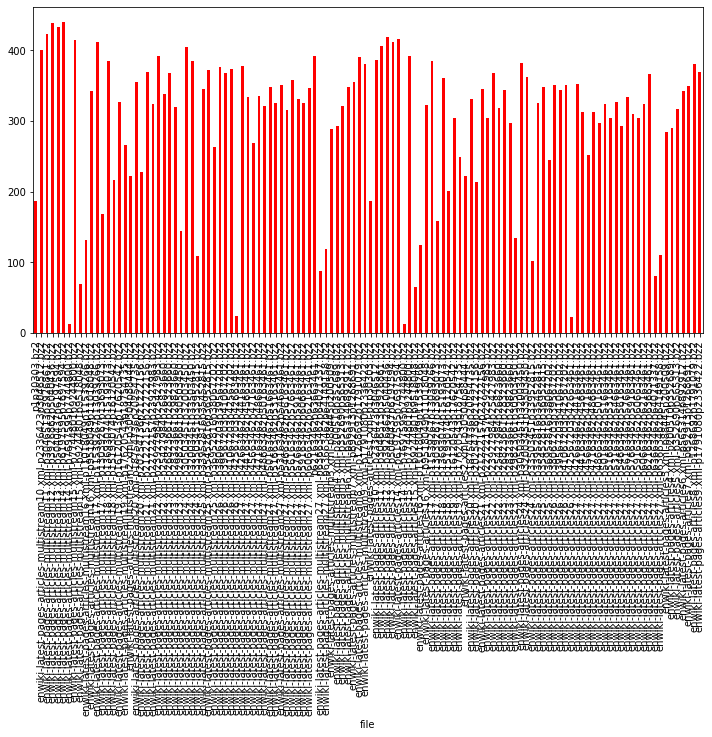

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
file_df = pd.DataFrame(file_info, columns = ['file', 'size (MB)', 'articles']).set_index('file')
file_df['size (MB)'].plot.bar(color = 'red', figsize = (12, 6));

Trazamos mediante un dataframe los diversos tamaños de los archivos



#### Tamaño Wikipedia 

Articulos de Wikipedia

* [Tamaño Wikipedia](https://en.wikipedia.org/wiki/Wikipedia:Size_of_Wikipedia)
* [Crecimiento de modelado de Wikipedia](https://en.wikipedia.org/wiki/Wikipedia:Modelling_Wikipedia%27s_growth#Data_set_for_number_of_articles)
* [Comparativa de tamaño de wikipedia con otras enciclopedias](https://en.wikipedia.org/wiki/Wikipedia:Size_comparisons)

## Búsqueda de las palabras clave en los párrafos de Wikipedia.

In [28]:
from pathlib import Path
path = []
keras_home = '/Users/prosy/.keras/datasets/'

def ls(ruta = Path.cwd()):
    return [arch.name for arch in Path(ruta).iterdir() if arch.is_file()]

path = ls(keras_home)
path

['enwiki-latest-pages-articles-multistream1.xml-p1p30303',
 'enwiki-latest-pages-articles-multistream1.xml-p1p30303.bz2',
 'enwiki-latest-pages-articles-multistream10.xml-p2336423p3046512',
 'enwiki-latest-pages-articles-multistream10.xml-p2336423p3046512.bz2',
 'enwiki-latest-pages-articles-multistream11.xml-p3046513p3926861',
 'enwiki-latest-pages-articles-multistream11.xml-p3046513p3926861.bz2',
 'enwiki-latest-pages-articles-multistream12.xml-p3926862p5040436',
 'enwiki-latest-pages-articles-multistream12.xml-p3926862p5040436.bz2',
 'enwiki-latest-pages-articles-multistream13.xml-p5040437p6197594',
 'enwiki-latest-pages-articles-multistream13.xml-p5040437p6197594.bz2',
 'enwiki-latest-pages-articles-multistream14.xml-p6197595p7697594',
 'enwiki-latest-pages-articles-multistream14.xml-p6197595p7697594.bz2',
 'enwiki-latest-pages-articles-multistream14.xml-p7697595p7744800.bz2',
 'enwiki-latest-pages-articles-multistream15.xml-p7744801p9244800.bz2',
 'enwiki-latest-pages-articles-mul

In [1]:
from lxml import etree
import csv
import wikitextparser as wtp
import re

lista = []

class WikiLinkTextProcessor:

    def __init__(self, input_xml):
        self.input_xml = input_xml
        self.wikilinks = {} # key is wikilink text, value is set of stringified Wikilink objects
    

    @staticmethod
    def stringify_wikilink(title, wikilink):
      
        wikilink = title + "@" + wikilink.title + "|" + wikilink.string
      
          
        wikilink = wikilink.strip()
        wikilink = re.sub(r"[#\|]$","",wikilink)
        return  wikilink

    def add_text_link(self,title,text,wikilink):
        if text is None or re.match(r"^\s*$",text):
            return
        text = re.sub(r"\s+"," ",text).strip()
        if text not in self.wikilinks:
            self.wikilinks[text] = set()
        self.wikilinks[text].add(WikiLinkTextProcessor.stringify_wikilink(title, wikilink))
    

    def set_wikilinks(self):
        tree = etree.parse(self.input_xml)
        root = tree.getroot()
       
        print(root.findall(".//title"))
        # iterate through all the text
        for page in root.findall(".//page", namespaces=root.nsmap):
            title = page.findall(".//title", namespaces=page.nsmap)
            title = title[0].text
            for text in page.findall(".//text", namespaces=page.nsmap):
                if text.text is None or len(text.text.strip())==0:
                    continue
                parsed = wtp.parse(text.text)
                for section in parsed.sections:
                    section_title = section.title.strip()
                    section_text = section.string.strip()
                    for match in re.finditer(r'(?s)((?:[^\n][\n]?)+)', section_text):
                        result = []
                        result2 = []
                        result = (section_text[match.start():match.end()])
                        a = result.find('==')
                        result2 = result[a:match.end()]
                        for match in re.findall('Human overpopulation|Biocapacity climate change|Carrying capacity|Exploitation|Industrialisation|I = PAT|Land degradation|Land reclamation|Optimum population|Overshoot population, Population density|Population dynamics|Population growth|Projections of population growth|Total fertility rate|Urbanization|Wast|Water conflict|Water scarcity|Overdrafting|Environmental impacts of reservoirs|Tile drainage|Hydrology agriculture|Flooding|Landslide|Intensive farming|Agricultural subsidy|Environmental effects of meat production|Intensive animal farming|Intensive crop farming|Irrigation|Monoculture|Nutrient pollution|Overgrazing|Pesticide drift|Plasticulture|Slash and burn|Tile drainage|Built environment|Desertification|Habitat fragmentation|Habitat destruction|Land degradation|Land pollution|Lawn-environmental concerns|Trail ethics|Urban heat island|Urban sprawl|Impact of nanotechnology|Natural disasters|Nuclear fallout|Nuclear meltdown|Nuclear power|Nuclear weapons|Nuclear and radiation accidents|Nuclear safety|High-level radioactive waste management|Ocean trash|Water Pollution', result2,re.IGNORECASE):
                            global lista
                            linea_csv = ['TITULO: ' + title + ' SUBTITULO Y PARRAFO: ' + result2]
                            #print(linea_csv)
                            lista.append(linea_csv)
                            for link in section.wikilinks:
                                self.add_text_link(title, link.string, link)
    
    def get_wikilinks(self):
        return self.wikilinks_counter, self.wikilinks
                            

from pathlib import Path
path_file = []
keras_home = '/Users/prosy/.keras/datasets/prueba/'
output_csv = 'C:/Users/Prosy/Documents/Master Ciencia de Datos/TFM/salida/datos_minimos.csv'
def ls(ruta = Path.cwd()):
    return [arch.name for arch in Path(ruta).iterdir() if arch.is_file()]
path_file = ls(keras_home)
print("Listado de ficheros :")
print(path_file)
for path in path_file:
    input_xml = keras_home+path
    print("Comienza:" + path)
    processor = WikiLinkTextProcessor(input_xml)
    processor.set_wikilinks()

    with open(output_csv,"w", encoding="utf-8") as f:
        wr = csv.writer(f,delimiter="\n")
        for line in lista:
            wr.writerow(line)
    print("Termina de leer: " + path)


Listado de ficheros :
['enwiki-latest-pages-articles27.xml-p53163462p54663461', 'enwiki-latest-pages-articles27.xml-p54663462p56163461', 'enwiki-latest-pages-articles27.xml-p56163462p57663461', 'enwiki-latest-pages-articles27.xml-p57663462p59163461', 'enwiki-latest-pages-articles27.xml-p59163462p60663461', 'enwiki-latest-pages-articles27.xml-p60663462p62163461', 'enwiki-latest-pages-articles27.xml-p62163462p63260062', 'enwiki-latest-pages-articles27.xml-p62163462p63542866', 'enwiki-latest-pages-articles3.xml-p88445p200509', 'enwiki-latest-pages-articles4.xml-p200510p352689', 'enwiki-latest-pages-articles5.xml-p352690p565313', 'enwiki-latest-pages-articles6.xml-p565314p892912', 'enwiki-latest-pages-articles7.xml-p892913p1268691', 'enwiki-latest-pages-articles8.xml-p1268692p1791079', 'enwiki-latest-pages-articles9.xml-p1791080p2336422']
Comienza:enwiki-latest-pages-articles27.xml-p53163462p54663461
[]
Termina de leer: enwiki-latest-pages-articles27.xml-p53163462p54663461
Comienza:enwiki-

# Lectura del fichero  específica Keyword

In [32]:
import re
from collections import defaultdict
import pandas as pd

pandas_dict = defaultdict(list)


regex = r"TITULO: (.*) SUBTITULO Y PARRAFO: (={2,4})(.*?)\2\s*(.*)$"
with open("C:/Users/Prosy/Documents/Master Ciencia de Datos/TFM/salida/datos_minimos.csv", "r",encoding='utf-8') as f:
    test_str = f.read()
    matches = re.finditer(regex, test_str, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):
        for groupNum in range(0, len(match.groups())):
            groupNum = groupNum + 1
            if groupNum == 1:
                pandas_dict["title"].append(match.group(groupNum))
            if groupNum == 3:
                pandas_dict["head"].append(match.group(groupNum))
            if groupNum == 4:
                pandas_dict["text"].append(match.group(groupNum))
  
    df_keyword_sub = pd.DataFrame(pandas_dict)
    #df_keyword = pd.concat(tp, ignore_index=True)

In [33]:
df_keyword_sub

,title,head,text
0,Spanish Revolution of 1936,Environmentalism,The Spanish Revolution undertook several envir...
1,Rainmaking (ritual),China,[[Wu (shaman)#Wu-shamans as rainmakers|Wu Sham...
2,Rainmaking (ritual),China,[[Wu (shaman)#Wu-shamans as rainmakers|Wu Sham...
3,Alejandro Toledo,Fighting terrorism and drug trafficking,"The Truth and Reconciliation Commission, which..."
4,Alejandro Toledo,Fighting terrorism and drug trafficking,"The Truth and Reconciliation Commission, which..."
...,...,...,...
45071,Deforestation in Myanmar,Conservation,The longest standing forestry conservation pra...
45072,Hatgyi Dam,Controversy,=== Impact on local populations ===
45073,Hatgyi Dam,Environmental impact,Environmental researcher Steve Thompson of the...
45074,Hatgyi Dam,Impact on local populations,Concerns about the impact of the dam on local ...


### Eliminación de duplicados

In [37]:
df_keyword_sub_sin_dupli = df_keyword_sub.drop_duplicates(ignore_index=True)
df_keyword_sub_sin_dupli

,title,head,text
0,Spanish Revolution of 1936,Environmentalism,The Spanish Revolution undertook several envir...
1,Rainmaking (ritual),China,[[Wu (shaman)#Wu-shamans as rainmakers|Wu Sham...
2,Alejandro Toledo,Fighting terrorism and drug trafficking,"The Truth and Reconciliation Commission, which..."
3,Fraggle Rock,United Kingdom,Twelve UK episodes were released on VHS and DV...
4,Star Trek IV: The Voyage Home,Design,[[Industrial Light & Magic]] (ILM) was respons...
...,...,...,...
20372,Deforestation in Myanmar,The Ayeyarwady Delta,[[Ayeyarwady Region|The Ayeyarwady Delta Regio...
20373,Deforestation in Myanmar,Conservation,The longest standing forestry conservation pra...
20374,Hatgyi Dam,Controversy,=== Impact on local populations ===
20375,Hatgyi Dam,Environmental impact,Environmental researcher Steve Thompson of the...


# Crear un fichero nuevo de Keywords para luego hacer dataframe

In [14]:
filenames = ['datos_01_noduplicado.csv', 'datos_02_noduplicado.csv', 'datos_03_noduplicado.csv', 'datos_04_noduplicado.csv', 'datos_05_noduplicado.csv','datos_06_noduplicado.csv','datos_07_noduplicado.csv']
with open('salida_total_keyword.csv', 'w',encoding="utf-8") as outfile:
    for fname in filenames:
        with open(fname, encoding="utf-8") as infile:
            for line in infile:
                outfile.write(line)

KeyboardInterrupt: 

In [1]:
import re
from collections import defaultdict
import pandas as pd

pandas_dict = defaultdict(list)


regex = r"TITULO: (.*) SUBTITULO Y PARRAFO: (={2,4})(.*?)\2\s*(.*)$"
with open("datos_01_noduplicado.csv", "r",encoding='utf-8') as f:
    test_str = f.read()
    matches = re.finditer(regex, test_str, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):
        for groupNum in range(0, len(match.groups())):
            groupNum = groupNum + 1
            if groupNum == 1:
                pandas_dict["title"].append(match.group(groupNum))
            if groupNum == 3:
                pandas_dict["head"].append(match.group(groupNum))
            if groupNum == 4:
                pandas_dict["text"].append(match.group(groupNum))
  
    df_keyword_01 = pd.DataFrame(pandas_dict)
    #df_keyword = pd.concat(tp, ignore_index=True)

In [2]:
import re
from collections import defaultdict
import pandas as pd

pandas_dict = defaultdict(list)


regex = r"TITULO: (.*) SUBTITULO Y PARRAFO: (={2,4})(.*?)\2\s*(.*)$"
with open("datos_02_noduplicado.csv", "r",encoding='utf-8') as f:
    test_str = f.read()
    matches = re.finditer(regex, test_str, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):
        for groupNum in range(0, len(match.groups())):
            groupNum = groupNum + 1
            if groupNum == 1:
                pandas_dict["title"].append(match.group(groupNum))
            if groupNum == 3:
                pandas_dict["head"].append(match.group(groupNum))
            if groupNum == 4:
                pandas_dict["text"].append(match.group(groupNum))
  
    df_keyword_02 = pd.DataFrame(pandas_dict)
    #df_keyword = pd.concat(tp, ignore_index=True)

In [3]:
import re
from collections import defaultdict
import pandas as pd

pandas_dict = defaultdict(list)


regex = r"TITULO: (.*) SUBTITULO Y PARRAFO: (={2,4})(.*?)\2\s*(.*)$"
with open("datos_03_noduplicado.csv", "r",encoding='utf-8') as f:
    test_str = f.read()
    matches = re.finditer(regex, test_str, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):
        for groupNum in range(0, len(match.groups())):
            groupNum = groupNum + 1
            if groupNum == 1:
                pandas_dict["title"].append(match.group(groupNum))
            if groupNum == 3:
                pandas_dict["head"].append(match.group(groupNum))
            if groupNum == 4:
                pandas_dict["text"].append(match.group(groupNum))
  
    df_keyword_03 = pd.DataFrame(pandas_dict)
    #df_keyword = pd.concat(tp, ignore_index=True)

In [4]:
import re
from collections import defaultdict
import pandas as pd

pandas_dict = defaultdict(list)


regex = r"TITULO: (.*) SUBTITULO Y PARRAFO: (={2,4})(.*?)\2\s*(.*)$"
with open("datos_04_noduplicado.csv", "r",encoding='utf-8') as f:
    test_str = f.read()
    matches = re.finditer(regex, test_str, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):
        for groupNum in range(0, len(match.groups())):
            groupNum = groupNum + 1
            if groupNum == 1:
                pandas_dict["title"].append(match.group(groupNum))
            if groupNum == 3:
                pandas_dict["head"].append(match.group(groupNum))
            if groupNum == 4:
                pandas_dict["text"].append(match.group(groupNum))
  
    df_keyword_04 = pd.DataFrame(pandas_dict)
    #df_keyword = pd.concat(tp, ignore_index=True)

In [5]:
import re
from collections import defaultdict
import pandas as pd

pandas_dict = defaultdict(list)


regex = r"TITULO: (.*) SUBTITULO Y PARRAFO: (={2,4})(.*?)\2\s*(.*)$"
with open("datos_05_noduplicado.csv", "r",encoding='utf-8') as f:
    test_str = f.read()
    matches = re.finditer(regex, test_str, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):
        for groupNum in range(0, len(match.groups())):
            groupNum = groupNum + 1
            if groupNum == 1:
                pandas_dict["title"].append(match.group(groupNum))
            if groupNum == 3:
                pandas_dict["head"].append(match.group(groupNum))
            if groupNum == 4:
                pandas_dict["text"].append(match.group(groupNum))
  
    df_keyword_05 = pd.DataFrame(pandas_dict)
    #df_keyword = pd.concat(tp, ignore_index=True)

In [7]:
import re
from collections import defaultdict
import pandas as pd

pandas_dict = defaultdict(list)


regex = r"TITULO: (.*) SUBTITULO Y PARRAFO: (={2,4})(.*?)\2\s*(.*)$"
with open("datos_06_noduplicado.csv", "r",encoding='utf-8') as f:
    test_str = f.read()
    matches = re.finditer(regex, test_str, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):
        for groupNum in range(0, len(match.groups())):
            groupNum = groupNum + 1
            if groupNum == 1:
                pandas_dict["title"].append(match.group(groupNum))
            if groupNum == 3:
                pandas_dict["head"].append(match.group(groupNum))
            if groupNum == 4:
                pandas_dict["text"].append(match.group(groupNum))
  
    df_keyword_06 = pd.DataFrame(pandas_dict)
    #df_keyword = pd.concat(tp, ignore_index=True)

In [8]:
import re
from collections import defaultdict
import pandas as pd

pandas_dict = defaultdict(list)


regex = r"TITULO: (.*) SUBTITULO Y PARRAFO: (={2,4})(.*?)\2\s*(.*)$"
with open("datos_07_noduplicado.csv", "r",encoding='utf-8') as f:
    test_str = f.read()
    matches = re.finditer(regex, test_str, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):
        for groupNum in range(0, len(match.groups())):
            groupNum = groupNum + 1
            if groupNum == 1:
                pandas_dict["title"].append(match.group(groupNum))
            if groupNum == 3:
                pandas_dict["head"].append(match.group(groupNum))
            if groupNum == 4:
                pandas_dict["text"].append(match.group(groupNum))
  
    df_keyword_07 = pd.DataFrame(pandas_dict)
    #df_keyword = pd.concat(tp, ignore_index=True)

In [9]:
df_keyword_01

,title,head,text
0,Albedo,Trees,"Because forests generally have a low albedo, (..."
1,Albedo,Human activities,"Human activities (e.g., deforestation, farming..."
2,Abraham Lincoln,"U.S. House of Representatives, 1847–1849","[[File:Abraham Lincoln by Nicholas Shepherd, 1..."
3,Abraham Lincoln,Re-election,{{Main|1864 United States presidential election}}
4,Algeria,Research and alternative energy sources,Algeria has invested an estimated 100 billion ...
...,...,...,...
20251,Prostitution in France,Evaluation,Sarkozy did not attempt to produce a comprehen...
20252,Nuclear Information and Resource Service,International offices,NIRS and WISE have merged their operations and...
20253,Nuclear Information and Resource Service,Press,"On 15 May 2007, NIRS issued a report claiming ..."
20254,Nuclear Information and Resource Service,Controversy,"Critics accuse NIRS of fearmongering, and ques..."


In [10]:
df_keyword_02

,title,head,text
0,Franco-British Nuclear Forum,See also,{{Portal|Energy|Nuclear technology}}
1,East Aceh Regency,Economy,"This regency is rich in [[petroleum]], more so..."
2,Elsie Locke,Peace activism,Locke focused a lot more of her attention into...
3,The Doe Fund,Criticism,"Early in The Doe Fund's existence, George McDo..."
4,La Wantzenau,History,The terrain around the village is very flat an...
...,...,...,...
11537,Prostitution in Haiti,Oxfam,In February 2018 an investigation by ''[[The T...
11538,Vehicle recycling,European Union,"In 1997, the European Commission adopted a Pro..."
11539,Vehicle recycling,External links,{{Commons category|Automobile scrap yards}}
11540,List of infantry divisions of the Soviet Union...,11 – 20 Guards Rifle Division,*[[11th Guards Rifle Division]] (ex 18th Mosco...


In [11]:
df_keyword_03

,title,head,text
0,The Strange Death of Tory England,Cover,The pictorial dust cover of the book's [[first...
1,Sleeping while on duty,Police officers/security officers,* December 1947 – a [[Metropolitan Police Depa...
2,Jim Himes,Defense,"Himes states that """"we should reduce our prese..."
3,Busitema University,Faculty of Engineering,*[[Bachelor of Science]] in agricultural [[mec...
4,Sim Kee Boon,Changi Airport,As [[Permanent Secretary]] at the Communicatio...
...,...,...,...
37824,Landslide victory,External links,* [http://uspolitics.about.com/od/Electoral-Co...
37825,Typhoon Krovanh (2003),Elsewhere,Striking Luzon in the Philippines on August&nb...
37826,Cary Holladay,Works,"* ''The Deer in the Mirror'', Ohio State UP, 2..."
37827,Kanna Lakshminarayana,Agriculture,Kanna Lakshmi Narayana has also introduced dev...


In [12]:
df_keyword_04

,title,head,text
0,Strike Back (TV series),''Vengeance'' (2012),{{main|Strike Back: Vengeance}}
1,Dabur Research Foundation,Further reading,*{{cite journal |doi=10.1007/s12094-012-0883-2...
2,Fertility factor (demography),Rural residence,[[Total fertility rate]]s are higher among wom...
3,Fertility factor (demography),Rising income,[[File:TFR vs PPP 2015.png|thumb|300px|Graph o...
4,Fertility factor (demography),Population control,{{Further|Human population control}}
...,...,...,...
23884,Tondabayashi Jinaimachi,History,"About 1558([[Eiroku]] 1), Kosho-ji temple obta..."
23885,Dislocated worker funding,== Current Legislation (2000 - present),==
23886,Wikipedia:Articles for deletion/Nirmal Baby Va...,[[:Nirmal Baby Varghese (Editor)]],:{{la|Nirmal Baby Varghese (Editor)}} – (<incl...
23887,Montoya Ranch,History,"In 1874, Juliana and Victor Montoya ran a shee..."


In [13]:
df_keyword_05

,title,head,text
0,Fruit sector in Azerbaijan,Import and Exports,"In 2014, due to improvement of irrigation syst..."
1,Sevastopol Naval Base,History,"The construction of the port started in 1772, ..."
2,2019 Vancouver Whitecaps FC season,Out,"{| class=""""wikitable sortable"""" style=""""width:..."
3,Randy Fine,In the legislature,"In the state legislature, Fine has been an adv..."
4,Wikipedia:Administrators' noticeboard/Incident...,User:Waenceslaus,"{{atop|status=banned|Consensus is clear, {{use..."
...,...,...,...
39627,Helikon vortex separation process,See also,*[[South Africa and weapons of mass destruction]]
39628,Helikon vortex separation process,External links,*[http://www.globalsecurity.org/wmd/intro/u-ae...
39629,Dinosaur Island,DC: The New Frontier,Writer/artist [[Darwyn Cooke]] uses the island...
39630,Wonder Girl (Cassie Sandsmark),Young Justice,{{see also|Young Justice}}


In [14]:
df_keyword_06

,title,head,text
0,Çatalca,Population,"As of a November 22, 2000 census, the populati..."
1,A Trip to the Dentist,Themes,{{quote box|width=35%|quote=The narrative styl...
2,New Look (policy),Criticism of Massive Retaliation,What Dulles implied was that the United States...
3,Hyperspectral imaging,Environment,[[File:Hyper-Cam smokestack.png|thumb|upright=...
4,USCGC Matagorda (WPB-1303),Sea trials,"In September 2004, after all eight ships were ..."
...,...,...,...
75966,Otto Buggisch,Autumn 1944,"In Autumn, Buggisch's attachment to WA Pruef 7..."
75967,Mycteroperca fusca,Conservation,''Mycteroperca fusca'' has a limited range whe...
75968,Pantabangan–Carranglan Watershed Forest Reserve,History,Proclamation No. 561 was signed by then–Presid...
75969,Pantabangan–Carranglan Watershed Forest Reserve,Description,"[[File:Carranglan,Nueva Ecijajf4134 10.JPG|thu..."


In [15]:
df_keyword_07

,title,head,text
0,Avinash Kumar Agarwal,Articles,"* Avinash K Agarwal*, Bushra Ateeq, Tarun Gupt..."
1,Angela Brooks,Awards and honors,Brooks was a 2009 National AIA Young Architect...
2,Dead Ringer Tour,Set list,===1981 US and 1982 European and US Tours===
3,Dead Ringer Tour,1981 US and 1982 European and US Tours,"""TITULO: List of Vice episodes SUBTITULO Y PAR..."
4,List of Vice episodes,Season 5 (2017),{{Episode table |background=#495A61|overall=5 ...
...,...,...,...
36504,List of Acts of Parliament in Singapore,2020,*[[Active Mobility (Amendment) Act 2020]]
36505,"Big Spring Park (Huntsville, Alabama)",The Park,[[File:BSP Bridge.jpg|right|thumb|The Japanese...
36506,French Institute of Pondicherry,Fields of research,* The IFP is composed of four departments. Yet...
36507,MasterFormat,Related Organizational Formats,*SectionFormat<ref>{{cite web |title=SectionFo...


In [29]:
df_keyword = pd.concat([df_keyword_01,df_keyword_02,df_keyword_03, df_keyword_04, df_keyword_05, df_keyword_06, df_keyword_07], ignore_index=True)

In [30]:
df_keyword

,title,head,text
0,Albedo,Trees,"Because forests generally have a low albedo, (..."
1,Albedo,Human activities,"Human activities (e.g., deforestation, farming..."
2,Abraham Lincoln,"U.S. House of Representatives, 1847–1849","[[File:Abraham Lincoln by Nicholas Shepherd, 1..."
3,Abraham Lincoln,Re-election,{{Main|1864 United States presidential election}}
4,Algeria,Research and alternative energy sources,Algeria has invested an estimated 100 billion ...
...,...,...,...
245623,List of Acts of Parliament in Singapore,2020,*[[Active Mobility (Amendment) Act 2020]]
245624,"Big Spring Park (Huntsville, Alabama)",The Park,[[File:BSP Bridge.jpg|right|thumb|The Japanese...
245625,French Institute of Pondicherry,Fields of research,* The IFP is composed of four departments. Yet...
245626,MasterFormat,Related Organizational Formats,*SectionFormat<ref>{{cite web |title=SectionFo...


In [33]:
df_keyword = pd.DataFrame(np.sort(df_keyword.values, axis=0), index=df_keyword.index, columns=df_keyword.columns)


In [34]:
df_keyword

,title,head,text
0,"""""No Snow, No Show"""" for the Eskimo",,!
1,"""""No Snow, No Show"""" for the Eskimo",,! !! Title !! Year of Publication !! Notes
2,"""""W"""" Is for Wasted",,! !! Title !! Year of Publication !! Notes
3,"""""W"""" Is for Wasted",,! '''#''' !! '''Title''' !! '''Plot''' !!
4,"""""W"""" Is for Wasted",,! Act no. !! Short title
...,...,...,...
245623,Șendreni,”Wiesenbauschule“,"•On March 31, 1975, [[Western Airlines]] Fligh..."
245624,Ḥalil (Bernstein),†Dicynodonts,↵↵===2021 BCHL Fred Page Cup playoffs===↵↵{{16...
245625,Ḥalil (Bernstein),†Dicynodonts,↵↵===2021 BCHL Fred Page Cup playoffs===↵↵{{16...
245626,‘Ōma’o,†[[Sauropoda|Sauropods]],新疆生产建设兵团第三师托云牧场前身是由1951年1月二军后勤部的托云、木吉、英尔、阿英四个羊...


In [18]:
# drop duplicate rows
df_keyword_drop = df_keyword.drop_duplicates(ignore_index=True)

In [35]:
df_keyword_drop

,title,head,text
0,Albedo,Trees,"Because forests generally have a low albedo, (..."
1,Albedo,Human activities,"Human activities (e.g., deforestation, farming..."
2,Abraham Lincoln,"U.S. House of Representatives, 1847–1849","[[File:Abraham Lincoln by Nicholas Shepherd, 1..."
3,Abraham Lincoln,Re-election,{{Main|1864 United States presidential election}}
4,Algeria,Research and alternative energy sources,Algeria has invested an estimated 100 billion ...
...,...,...,...
125203,Werner Best,Bibliography,* {{cite book | last=Brustin-Berenstein | firs...
125204,Onsite sewage facility,See also,"* [[Sewage farm]]"""
125205,Brent Sherman,ARCA Racing Series,! William Fain
125206,Cold Water Music,Track listing,| title2 = Cold Water Music


In [36]:
duplicateRowsDF = df_keyword_drop[df_keyword_drop.duplicated(['title','text'])]

In [37]:
duplicateRowsDF

,title,head,text
188,Demographics of Bosnia and Herzegovina,=Brčko District,=
8131,Tendency of the rate of profit to fall,= Exploitation issue,=
11050,Zero-energy building,=Kentucky,=
12178,Human rights in the Philippines,=Programmes and projects,=
12494,Human overpopulation,=Global perspective on food supply,=
...,...,...,...
123667,Wikipedia:Requests for adminship/Jbhunley,=Oppose,=
123668,Wikipedia:Requests for adminship/Jbhunley,=Neutral,=
124396,Human reproductive ecology,=Quality-quantity trade-offs in fertility,=
124431,Hurricane Michael,=Elsewhere in Florida,=


In [27]:
duplicateRowsDF.sort_values('text')

,title,head,text
23212,Wikipedia:Requests for adminship/Danny 2,Oppose,</noinclude>
188,Demographics of Bosnia and Herzegovina,=Brčko District,=
64160,Wikipedia:PC2012/RfC 2,=Yes (vandalism),=
64866,Hurricane Sandy,=Pennsylvania,=
64872,Hurricane Sandy,=Florida,=
...,...,...,...
49205,Wikipedia:Sockpuppet investigations/Justin2002...,"==<span style=""""font-size:150%""""> Clerk, patro...",==
49169,Wikipedia:Sockpuppet investigations/Ihcoyc/Arc...,"==<span style=""""font-size:150%""""> CheckUser re...",==
44478,Wikipedia:Miscellany for deletion/Wikipedia:Ar...,==Section break 3,==
75282,Water in Arkansas,==Solid Waste,==


In [28]:
duplicateRowsDF.to_csv('salida_head_diferente_mismo_parrafo.csv', index = False, header=True)

In [23]:
salida = duplicateRowsDF[duplicateRowsDF.duplicated(['title'])]

In [24]:
salida

,title,head,text
8131,Tendency of the rate of profit to fall,= Exploitation issue,=
11050,Zero-energy building,=Kentucky,=
12178,Human rights in the Philippines,=Programmes and projects,=
12494,Human overpopulation,=Global perspective on food supply,=
13436,1915 Galveston hurricane,=Ohio River Valley,=
...,...,...,...
125058,Warabandi system,References,{{Irrigation by country}}
125119,Dizzy Wright discography,Guest appearances,"! scope=""""col"""" | Other artist(s)"
125131,Advanced Gas-cooled Reactor,See also,"*[[Nuclear power in the United Kingdom]]"""
125136,Four Asian Tigers,Demographics,"|- style=""""background:#ececec;"""""


# DBPedia Spotlight

Listado de palabras sinónimas con respecto a las palabras claves, que son 57 palabras claves

SELECT DISTINCT ?issue WHERE {VALUES ?issue{
<http://dbpedia.org/resource/Deforestation>
<http://dbpedia.org/resource/Pollution>
<http://dbpedia.org/resource/Human_overpopulation>
<http://dbpedia.org/resource/Biocapacity>
<http://dbpedia.org/resource/Climate_change>
<http://dbpedia.org/resource/Carrying_capacity>
<http://dbpedia.org/resource/Industrialisation>
<http://dbpedia.org/resource/I_=_PAT>
<http://dbpedia.org/resource/Land_degradation>
<http://dbpedia.org/resource/Land_reclamation>
<http://dbpedia.org/resource/Optimum_population>
<http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density>
<http://dbpedia.org/resource/Population_dynamics>
<http://dbpedia.org/resource/Total_fertility_rate>
<http://dbpedia.org/resource/Urbanization>
<http://dbpedia.org/resource/Water_conflict>
<http://dbpedia.org/resource/Water_scarcity>
<http://dbpedia.org/resource/Overdrafting>
<http://dbpedia.org/resource/Tile_drainage>
<http://dbpedia.org/resource/Agriculture>
<http://dbpedia.org/resource/Intensive_farming>
<http://dbpedia.org/resource/Agricultural_subsidy>
<http://dbpedia.org/resource/Intensive_animal_farming>
<http://dbpedia.org/resource/Nutrient_pollution>
<http://dbpedia.org/resource/Overgrazing>
<http://dbpedia.org/resource/Pesticide_drift>
<http://dbpedia.org/resource/Plasticulture>
<http://dbpedia.org/resource/Tile_drainage>
<http://dbpedia.org/resource/Built_environment>
<http://dbpedia.org/resource/Desertification>
<http://dbpedia.org/resource/Habitat_fragmentation>
<http://dbpedia.org/resource/Habitat_destruction>
<http://dbpedia.org/resource/Land_degradation>
<http://dbpedia.org/resource/Trail_ethics>
<http://dbpedia.org/resource/Urban_heat_island>
<http://dbpedia.org/resource/Urban_sprawl>
<http://dbpedia.org/resource/Nanotechnology>
<http://dbpedia.org/resource/Nuclear_fallout>
<http://dbpedia.org/resource/Nuclear_meltdown>
<http://dbpedia.org/resource/Radioactive_decay>
<http://dbpedia.org/resource/Nuclear_safety_and_security>
<http://dbpedia.org/resource/High-level_radioactive_waste_management>
<http://dbpedia.org/resource/Monoculture>
<http://dbpedia.org/resource/Irrigation>
<http://dbpedia.org/resource/Urbanization>
<http://dbpedia.org/resource/Swamp>
<http://dbpedia.org/resource/Landslide>
<http://dbpedia.org/resource/Industrialisation>
    }
 ?issue ?a ?b} 

#### Con respecto a las palabras claves se busca las palabras sinónimas mediante wordnet.

In [21]:
import nltk 
from nltk.corpus import wordnet 
synonyms = [] 
antonyms = [] 
key_list = ['human overpopulation','biocapacity climate change','carrying capacity','exploitation','industrialisation','i = pat','land degradation','land reclamation','optimum population','overshoot population', 'population density','population dynamics','population growth','projections of population growth','total fertility rate','urbanization','wast','water conflict','water scarcity','overdrafting','environmental impacts of reservoirs','tile drainage','hydrology agriculture','flooding','landslide','intensive farming','agricultural subsidy','environmental effects of meat production','intensive animal farming','intensive crop farming','irrigation','monoculture','nutrient pollution','overgrazing','pesticide drift','plasticulture','slash and burn','tile drainage','built environment','desertification','habitat fragmentation','habitat destruction','land degradation','land pollution','lawn-environmental concerns','trail ethics','urban heat island','urban sprawl','impact of nanotechnology','natural disasters','nuclear fallout','nuclear meltdown','nuclear power','nuclear weapons','nuclear and radiation accidents','nuclear safety','high-level radioactive waste management','ocean trash','water pollution']
for keyword in key_list:   
    for syn in wordnet.synsets(keyword): 
        for l in syn.lemmas(): 
            synonyms.append(l.name()) 


print(set(synonyms)) 
 

{'flooding', 'landslide', 'urbanisation', 'landslip', 'flood', 'industrial_enterprise', 'urbanization', 'inundate', 'glut', 'victimization', 'implosion_therapy', 'swamp', 'development', 'desertification', 'exploitation', 'irrigation', 'using', 'monoculture', 'deluge', 'industrialisation', 'victimisation', 'oversupply', 'industrialization'}


In [ ]:
from lxml import etree
import csv
import wikitextparser as wtp
import re
import json
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import urllib.parse
import pandas as pd

import requests
from IPython.core.display import display, HTML
# An API Error Exception
class APIError(Exception):
    def __init__(self, status):
        self.status = status
    def __str__(self):
        return "APIError: status={}".format(self.status)

lista = []
all_title = []
all_urls = []
all_texts = []
all_words = []

global D 
class WikiLinkTextProcessor:

    def __init__(self, input_xml):
        self.input_xml = input_xml
        self.wikilinks = {} # key is wikilink text, value is set of stringified Wikilink objects
    

    @staticmethod
    def stringify_wikilink(title, wikilink):
      
        wikilink = title + "@" + wikilink.title + "|" + wikilink.string
      
          
        wikilink = wikilink.strip()
        wikilink = re.sub(r"[#\|]$","",wikilink)
        return  wikilink

    def add_text_link(self,title,text,wikilink):
        if text is None or re.match(r"^\s*$",text):
            return
        text = re.sub(r"\s+"," ",text).strip()
        if text not in self.wikilinks:
            self.wikilinks[text] = set()
        self.wikilinks[text].add(WikiLinkTextProcessor.stringify_wikilink(title, wikilink))
    

    def set_wikilinks(self):
        tree = etree.parse(self.input_xml)
        root = tree.getroot()
       
        #print(root.findall(".//title"))
        # iterate through all the text
        for page in root.findall(".//page", namespaces=root.nsmap):
            title = page.findall(".//title", namespaces=page.nsmap)
            title = title[0].text
            
            for text in page.findall(".//text", namespaces=page.nsmap):
                if text.text is None or len(text.text.strip())==0:
                    continue
                parsed = wtp.parse(text.text)

                ## initial consts
                BASE_URL = 'http://api.dbpedia-spotlight.org/en/annotate?text={text}&confidence={confidence}&support={support}&sparql={sparql}'
                #print(BASE_URL)
                #print(type(section))
                #TEXT = open("/Users/prosy/.keras/datasets/enwiki-latest-pages-articles14.xml-p7697595p7744800","r",encoding='utf-8').read()
                
                TEXT = str(parsed)
                
                SPARQL = 'SELECT%20DISTINCT%20%3Fissue%20WHERE%20%7BVALUES%20%3Fissue%7B%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FDeforestation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FPollution%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FHuman_overpopulation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FBiocapacity%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FClimate_change%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FCarrying_capacity%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FIndustrialisation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FI_%3D_PAT%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FLand_degradation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FLand_reclamation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FOptimum_population%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FList_of_countries_and_territories_by_population_density%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FPopulation_dynamics%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FTotal_fertility_rate%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FUrbanization%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FWater_conflict%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FWater_scarcity%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FOverdrafting%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FTile_drainage%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FAgriculture%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FIntensive_farming%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FAgricultural_subsidy%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FIntensive_animal_farming%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FNutrient_pollution%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FOvergrazing%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FPesticide_drift%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FPlasticulture%3E%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FTile_drainage%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FBuilt_environment%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FDesertification%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FHabitat_fragmentation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FHabitat_destruction%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FLand_degradation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FTrail_ethics%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FUrban_heat_island%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FUrban_sprawl%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FNanotechnology%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FNuclear_fallout%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FNuclear_meltdown%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FRadioactive_decay%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FNuclear_safety_and_security%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FHigh-level_radioactive_waste_management%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FMonoculture%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FIrrigation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FUrbanization%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FSwamp%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FLandslide%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FIndustrialisation%3E%20%20%20%20%20%7D%20%20%3Fissue%20%3Fa%20%3Fb%7D%20'
               
                CONFIDENCE = '0.2'
                SUPPORT = '20'
                REQUEST = BASE_URL.format(
                    text=urllib.parse.quote_plus(TEXT), 
                    confidence=CONFIDENCE, 
                    support=SUPPORT,
                    sparql=SPARQL
                )
                HEADERS = {'Accept': 'application/json'}
                
                r = requests.get(url=REQUEST, headers=HEADERS)
                if r.status_code == requests.codes['ok']:
                    response = r.json()     
                    resources = response.get('Resources', [])
                    for res in resources:
                        print("03.....Parte de la URI y parte de surfaceForm")                                      
                        all_title.append(title)
                        all_words.append(res['@surfaceForm']) 
                        all_urls.append(res['@URI'])
                        all_texts.append(response['@text'])
                    df = pd.DataFrame(
                        {'titulo' : all_title,
                        'Palabra': all_words,
                        'Uri': all_urls,
                        'Texto': all_texts
                        })   

                    df = df.append(df)                     
            
                    df.to_csv(output_csv, index = False, header=True, sep="#", mode='a')
    
    def get_wikilinks(self):
        return self.wikilinks_counter, self.wikilinks
                            

from pathlib import Path
path_file = []
keras_home = '/Users/prosy/.keras/datasets/Run/'
#['salida_ner1.csv', 'salida_ner2.csv', 'salida_ner3.csv', 'salida_ner4.csv', 'salida_ner6.csv', 'salida_ner7.csv', 'salida_ner8.csv']
output_csv = 'C:/Users/Prosy/Documents/Master Ciencia de Datos/TFM/salida_ner1.csv'
def ls(ruta = Path.cwd()):
    return [arch.name for arch in Path(ruta).iterdir() if arch.is_file()]
path_file = ls(keras_home)
print("Listado de ficheros :")
print(path_file)
for path in path_file:
    input_xml = keras_home+path
    print("Comienza:" + path)
    processor = WikiLinkTextProcessor(input_xml)
    processor.set_wikilinks()

    print("Termina de leer: " + path)


  

Listado de ficheros :
['enwiki-latest-pages-articles-multistream7.xml-p892913p1268691']
Comienza:enwiki-latest-pages-articles-multistream7.xml-p892913p1268691

In [ ]:
df = pd.DataFrame(
                        {
                        'titulo' : all_title,
                        'Palabra': all_words,
                        'Uri': all_urls,
                        'Texto': all_texts
                        })


In [ ]:
df

In [52]:
filenames = ['salida_ner1.csv', 'salida_ner2.csv', 'salida_ner3.csv', 'salida_ner4.csv', 'salida_ner6.csv', 'salida_ner7.csv', 'salida_ner8.csv']
with open('salida_total_ner.csv', 'w',encoding="utf-8") as outfile:
    for fname in filenames:
        with open(fname, encoding="utf-8") as infile:
            for line in infile:
                outfile.write(line)

In [1]:
import pandas as pd
data = pd.read_csv("salida_total_ner.csv",  delimiter='#')

In [2]:
data_dbpedia = data[['titulo']]
data_dbpedia.rename(columns={'titulo':'dbpedia'}, inplace=True)
data_dbpedia_repla = data_dbpedia.replace(' ', '_', regex=True)
#df['col2'] = np.where(df.col2.isin(samples.Sam),'Yes' + df.col2, 'Non_'+ df.col2)
data_dbpedia_repla['dbpedia'] = 'http://dbpedia.org/resource/' + data_dbpedia_repla['dbpedia'].astype(str)
data_dbpedia_repla
data['dbpedia'] = data_dbpedia_repla
data

C:\Users\Prosy\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,titulo,Palabra,Uri,Texto,dbpedia
0,titulo,Palabra,Uri,Texto,http://dbpedia.org/resource/titulo
1,titulo,Palabra,Uri,Texto,http://dbpedia.org/resource/titulo
2,titulo,Palabra,Uri,Texto,http://dbpedia.org/resource/titulo
3,titulo,Palabra,Uri,Texto,http://dbpedia.org/resource/titulo
4,titulo,Palabra,Uri,Texto,http://dbpedia.org/resource/titulo
...,...,...,...,...,...
3578640,Wikipedia:Today's featured article/December 27...,scarcity,http://dbpedia.org/resource/Water_scarcity,"<div style=""float:left;margin-right:0.9em"">\r\...",http://dbpedia.org/resource/Wikipedia:Today's_...
3578641,Avoid the Noid (video game),activated,http://dbpedia.org/resource/Radioactive_decay,{{for|the video game for the NES|Yo! Noid}}\r\...,http://dbpedia.org/resource/Avoid_the_Noid_(vi...
3578642,"Beauce, France",agricultural,http://dbpedia.org/resource/Agriculture,{{Other uses|Beauce (disambiguation){{!}}Beauc...,"http://dbpedia.org/resource/Beauce,_France"
3578643,War Finance Corporation,agricultural,http://dbpedia.org/resource/Agriculture,{{more references|date=April 2008}}\r\nThe '''...,http://dbpedia.org/resource/War_Finance_Corpor...


In [3]:
# drop duplicate rows
data_drop = data.drop_duplicates(ignore_index=True)



In [5]:
data_drop



,titulo,Palabra,Uri,Texto,dbpedia
0,titulo,Palabra,Uri,Texto,http://dbpedia.org/resource/titulo
1,Sargus Juvenile Detention Center,structures,http://dbpedia.org/resource/Built_environment,{{Unreferenced|date=June 2019|bot=noref (Green...,http://dbpedia.org/resource/Sargus_Juvenile_De...
2,Sri Karan Narendra College of Agriculture,agriculture,http://dbpedia.org/resource/Agriculture,{{Use dmy dates|date=July 2018}}\r\n{{Use Indi...,http://dbpedia.org/resource/Sri_Karan_Narendra...
3,Jacob Pledger House,agricultural,http://dbpedia.org/resource/Agriculture,{{Infobox NRHP\r\n| name = Jacob Pledger House...,http://dbpedia.org/resource/Jacob_Pledger_House
4,Nehemiah Hubbard House,farming,http://dbpedia.org/resource/Agriculture,{{Infobox NRHP | name =Nehemiah Hubbard House\...,http://dbpedia.org/resource/Nehemiah_Hubbard_H...
...,...,...,...,...,...
369,Wikipedia:Today's featured article/December 27...,scarcity,http://dbpedia.org/resource/Water_scarcity,"<div style=""float:left;margin-right:0.9em"">\r\...",http://dbpedia.org/resource/Wikipedia:Today's_...
370,Avoid the Noid (video game),activated,http://dbpedia.org/resource/Radioactive_decay,{{for|the video game for the NES|Yo! Noid}}\r\...,http://dbpedia.org/resource/Avoid_the_Noid_(vi...
371,"Beauce, France",agricultural,http://dbpedia.org/resource/Agriculture,{{Other uses|Beauce (disambiguation){{!}}Beauc...,"http://dbpedia.org/resource/Beauce,_France"
372,War Finance Corporation,agricultural,http://dbpedia.org/resource/Agriculture,{{more references|date=April 2008}}\r\nThe '''...,http://dbpedia.org/resource/War_Finance_Corpor...


In [4]:
data_drop.to_csv('salida_spotlight.csv', index = False, header=True)

In [6]:
Concepto = data_drop[['Palabra']]

In [7]:
Concepto_drop = Concepto.drop_duplicates(ignore_index=True)
Concepto_drop

,Palabra
0,Palabra
1,structures
2,agriculture
3,agricultural
4,farming
...,...
101,fogging
102,intensively
103,agricultural product
104,fragmentation


In [8]:
Concepto_drop.to_csv('salida_palabras_genericas.csv', index = False, header=True)

In [9]:
no_contiene = 'Palabra|structures|agriculture|agricultural|farming|Agriculture|activity|nanoscience|produce|Agricultural|safety|facility|irrigated|decay|reclaimed|fragmented|swamp|nanotechnology|Nanotechnology|nanoscale|farm|climate|farmers|crops|Land reclamation|reclaim|irrigation|cultivated|conventional|watering|agricultural products|agriculturally|Farming|nanotech|fragments|agrarian|farmland|crop|Activity|environments|industrial|loss|vanished|Nanotech|machines|Fallout|activated|cultivate|farms|swamps|Farmers|swampy|farmer|fallout|intensive|Agro|sliding|urbanised|infilled|swampland|urbanisation|Swamp|fogging|intensively|agricultural product|fragmentation|fogging|intensively|agricultural product|fragmentation|scarcity'

In [10]:
df_no_contiene = data_drop[~data_drop["Palabra"].str.contains(no_contiene)]

In [11]:
df_no_contiene

,titulo,Palabra,Uri,Texto,dbpedia
14,Jack Brabham (album),Decay,http://dbpedia.org/resource/Radioactive_decay,{{multiple issues|\r\n{{Refimprove|date=Septem...,http://dbpedia.org/resource/Jack_Brabham_(album)
20,Council for the Australian Federation,Climate Change,http://dbpedia.org/resource/Climate_change,{{Use dmy dates|date=July 2019}}\r\nThe '''Cou...,http://dbpedia.org/resource/Council_for_the_Au...
24,Melbourne Press Club,Climate Change,http://dbpedia.org/resource/Climate_change,{{Use dmy dates|date=October 2011}}\r\n{{Use A...,http://dbpedia.org/resource/Melbourne_Press_Club
26,Jihozápad,population density,http://dbpedia.org/resource/List_of_countries_...,{{Infobox settlement\r\n<!-- See Template:Info...,http://dbpedia.org/resource/Jihozápad
31,Stuart Morris,pollution,http://dbpedia.org/resource/Pollution,{{for|the British Olympic hockey player|Stuart...,http://dbpedia.org/resource/Stuart_Morris
...,...,...,...,...,...
350,Drumskinny,Environment,http://dbpedia.org/resource/Built_environment,{{Use dmy dates|date=October 2019}}\r\n{{Infob...,http://dbpedia.org/resource/Drumskinny
351,"Kameda, Niigata",population density,http://dbpedia.org/resource/List_of_countries_...,{{Unreferenced|date=December 2009}}\r\n{{Infob...,"http://dbpedia.org/resource/Kameda,_Niigata"
352,"Ōshima, Niigata",population density,http://dbpedia.org/resource/List_of_countries_...,{{Refimprove|date=September 2015}}\r\n{{Infobo...,"http://dbpedia.org/resource/Ōshima,_Niigata"
353,"Shirahama, Chiba",population density,http://dbpedia.org/resource/List_of_countries_...,"{{confuse|Shirahama,Wakayama}}\r\n{{Infobox ci...","http://dbpedia.org/resource/Shirahama,_Chiba"


In [12]:
dbpedia_lista_url = df_no_contiene[['dbpedia']]
dbpedia_lista_url_palabra_titulo = df_no_contiene[['titulo','Palabra','dbpedia']]

In [13]:
dbpedia_lista_url.to_csv('dbpedia_lista_url.csv', index = False, header=True)
dbpedia_lista_url_palabra_titulo.to_csv('dbpedia_lista_url_palabra_titulo.csv', index = False, header=True)

In [14]:
dbpedia_lista_url

,dbpedia
14,http://dbpedia.org/resource/Jack_Brabham_(album)
20,http://dbpedia.org/resource/Council_for_the_Au...
24,http://dbpedia.org/resource/Melbourne_Press_Club
26,http://dbpedia.org/resource/Jihozápad
31,http://dbpedia.org/resource/Stuart_Morris
...,...
350,http://dbpedia.org/resource/Drumskinny
351,"http://dbpedia.org/resource/Kameda,_Niigata"
352,"http://dbpedia.org/resource/Ōshima,_Niigata"
353,"http://dbpedia.org/resource/Shirahama,_Chiba"


In [42]:
dbpedia_listado = dbpedia_lista_url.values.tolist()

In [43]:
dbpedia_listado

[['http://dbpedia.org/resource/Jack_Brabham_(album)'],
 ['http://dbpedia.org/resource/Council_for_the_Australian_Federation'],
 ['http://dbpedia.org/resource/Melbourne_Press_Club'],
 ['http://dbpedia.org/resource/Jihozápad'],
 ['http://dbpedia.org/resource/Stuart_Morris'],
 ['http://dbpedia.org/resource/Chief_veterinary_officer'],
 ['http://dbpedia.org/resource/Radium_jaw'],
 ['http://dbpedia.org/resource/Gorgonin'],
 ['http://dbpedia.org/resource/States_of_the_Federated_States_of_Micronesia'],
 ['http://dbpedia.org/resource/Larmor-Plage'],
 ['http://dbpedia.org/resource/Biological_exponential_growth'],
 ['http://dbpedia.org/resource/Biological_exponential_growth'],
 ['http://dbpedia.org/resource/Vietnam_partridge'],
 ['http://dbpedia.org/resource/Wikipedia:Peer_review/Kobe/archive1'],
 ['http://dbpedia.org/resource/Sanjaynagar'],
 ['http://dbpedia.org/resource/Young_River_(New_Zealand)'],
 ['http://dbpedia.org/resource/Young_River_(New_Zealand)'],
 ['http://dbpedia.org/resource/Dunuko

In [44]:
dbpedia_listado = str(dbpedia_listado).replace("'", '"')

In [45]:
dbpedia_listado = str(dbpedia_listado).replace("[", '')

In [46]:
dbpedia_listado = str(dbpedia_listado).replace("]", '')

In [47]:
dbpedia_listado = str(dbpedia_listado).replace("\\", '')

In [21]:
dbpedia_listado = str(dbpedia_listado).replace(" ", '')

In [51]:
dbpedia_listado = str(dbpedia_listado).replace("'", '')

In [52]:
dbpedia_listado

'"http://dbpedia.org/resource/Jack_Brabham_(album)", "http://dbpedia.org/resource/Council_for_the_Australian_Federation", "http://dbpedia.org/resource/Melbourne_Press_Club", "http://dbpedia.org/resource/Jihozápad", "http://dbpedia.org/resource/Stuart_Morris", "http://dbpedia.org/resource/Chief_veterinary_officer", "http://dbpedia.org/resource/Radium_jaw", "http://dbpedia.org/resource/Gorgonin", "http://dbpedia.org/resource/States_of_the_Federated_States_of_Micronesia", "http://dbpedia.org/resource/Larmor-Plage", "http://dbpedia.org/resource/Biological_exponential_growth", "http://dbpedia.org/resource/Biological_exponential_growth", "http://dbpedia.org/resource/Vietnam_partridge", "http://dbpedia.org/resource/Wikipedia:Peer_review/Kobe/archive1", "http://dbpedia.org/resource/Sanjaynagar", "http://dbpedia.org/resource/Young_River_(New_Zealand)", "http://dbpedia.org/resource/Young_River_(New_Zealand)", "http://dbpedia.org/resource/Dunukofia", "http://dbpedia.org/resource/Tony_Kirkham", "h

In [29]:
%%capture
#Install some essential packages
%pip install SPARQLWrapper pandas folium
# Import the necessary packages
from SPARQLWrapper import SPARQLWrapper, JSON

# Add some helper functions

# A function that will return the results of running a SPARQL query with 
# a defined set of prefixes over a specified endpoint.
# It follows the same five-step process apart from creating the query, which 
# is provided as an argument to the function.
def runQuery(endpoint, prefix, q):
    ''' Run a SPARQL query with a declared prefix over a specified endpoint '''
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(prefix+q) # concatenate the strings representing the prefixes and the query
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()
    
# Import pandas to provide facilities for creating a DataFrame to hold results
import pandas as pd

# Function to convert query results into a DataFrame
# The results are assumed to be in JSON format and therefore the Python dictionary will have  
# the results indexed by 'results' and then 'bindings'. 
def dict2df(results):
    ''' A function to flatten the SPARQL query results and return the column values '''
    data = []
    for result in results["results"]["bindings"]:
        tmp = {}
        for el in result:
            tmp[el] = result[el]['value']
        data.append(tmp)

    df = pd.DataFrame(data)
    return df

# Function to run a query and return results in a DataFrame
def dfResults(endpoint, prefix, q):
    ''' Generate a data frame containing the results of running
        a SPARQL query with a declared prefix over a specified endpoint '''
    return dict2df(runQuery(endpoint, prefix, q))
        
# Print a limited number of results of a query
def printQuery(results, limit=''):
    ''' Print the results from the SPARQL query '''
    resdata = results["results"]["bindings"]
    if limit != '':
        resdata = results["results"]["bindings"][:limit]
    for result in resdata:
        for ans in result:
            print('{0}: {1}'.format(ans, result[ans]['value']))
        print()

# Run a query and print out a limited number of results
def printRunQuery(endpoint, prefix, q, limit=''):
    ''' Print the results from the SPARQL query '''
    results = runQuery(endpoint, prefix, q)
    printQuery(results, limit)



In [30]:
# Define any prefixes
prefix = '''
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX dbpedia: <http://dbpedia.org/resource/>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX dbo: <http://dbpedia.org/ontology/>
    PREFIX dbc: <http://dbpedia.org/resource/Category:>
    PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>
    
    PREFIX ouseful:<http://ouseful.info/>
'''

In [31]:

#Declare the DBPedia endpoint
endpoint="http://dbpedia.org/sparql"
sparql = SPARQLWrapper(endpoint)

In [53]:
q = '''
SELECT DISTINCT ?label ?subject  ?lat ?long WHERE {
  ?subject geo:lat ?lat.
  ?subject geo:long ?long.
  ?subject rdfs:label ?label .
FILTER(str(?subject) IN ('''+dbpedia_listado+'''))
FILTER langMatches(lang(?label),'en')

} 
'''

In [39]:

q = '''
SELECT DISTINCT ?label ?subject  ?lat ?long WHERE {
  ?subject geo:lat ?lat.
  ?subject geo:long ?long.
  ?subject rdfs:label ?label .
FILTER(str(?subject) IN ("http://dbpedia.org/resource/Jack_Brabham_(album)","http://dbpedia.org/resource/Council_for_the_Australian_Federation","http://dbpedia.org/resource/Melbourne_Press_Club","http://dbpedia.org/resource/Jihozápad","http://dbpedia.org/resource/Stuart_Morris","http://dbpedia.org/resource/Chief_veterinary_officer","http://dbpedia.org/resource/Radium_jaw","http://dbpedia.org/resource/Gorgonin","http://dbpedia.org/resource/States_of_the_Federated_States_of_Micronesia","http://dbpedia.org/resource/Larmor-Plage","http://dbpedia.org/resource/Biological_exponential_growth","http://dbpedia.org/resource/Biological_exponential_growth","http://dbpedia.org/resource/Vietnam_partridge","http://dbpedia.org/resource/Sanjaynagar","http://dbpedia.org/resource/Young_River_(New_Zealand)","http://dbpedia.org/resource/Young_River_(New_Zealand)","http://dbpedia.org/resource/Dunukofia","http://dbpedia.org/resource/Tony_Kirkham","http://dbpedia.org/resource/Philip_Wheeler_Conkling","http://dbpedia.org/resource/Demographics_of_Wallis_and_Futuna","http://dbpedia.org/resource/List_of_meteorological_phenomena","http://dbpedia.org/resource/Parry_Peninsula","http://dbpedia.org/resource/Committee_on_Climate_Change_Science_and_Technology_Integration","http://dbpedia.org/resource/Committee_on_Climate_Change_Science_and_Technology_Integration","http://dbpedia.org/resource/Committee_on_Climate_Change_Science_and_Technology_Integration","http://dbpedia.org/resource/List_of_severe_weather_phenomena","http://dbpedia.org/resource/ACAP","http://dbpedia.org/resource/Portal:Primates/Selected_species/13","http://dbpedia.org/resource/Portal:Primates/Selected_species/13","http://dbpedia.org/resource/Californians_for_Population_Stabilization","http://dbpedia.org/resource/Battle_Creek,_Virginia","http://dbpedia.org/resource/Category:Anime_and_manga_articles_with_a_missing_image_caption","http://dbpedia.org/resource/Template:Geography_of_Macau","http://dbpedia.org/resource/Jordiyali","http://dbpedia.org/resource/AquaPedia","http://dbpedia.org/resource/AquaPedia","http://dbpedia.org/resource/Mortality","http://dbpedia.org/resource/Yawata","http://dbpedia.org/resource/Armoire_desk","http://dbpedia.org/resource/Boveney","http://dbpedia.org/resource/Cuban_crow","http://dbpedia.org/resource/Aira,_Kagoshima","http://dbpedia.org/resource/Hayato,_Kagoshima","http://dbpedia.org/resource/Ichinomiya,_Aichi_(town)","http://dbpedia.org/resource/Mizukami,_Kumamoto","http://dbpedia.org/resource/Tachiarai,_Fukuoka","http://dbpedia.org/resource/Kawara,_Fukuoka","http://dbpedia.org/resource/Itoda,_Fukuoka","http://dbpedia.org/resource/Mihara,_Kōchi","http://dbpedia.org/resource/East_Burra","http://dbpedia.org/resource/Susami,_Wakayama","http://dbpedia.org/resource/Udono,_Mie","http://dbpedia.org/resource/Izunagaoka,_Shizuoka","http://dbpedia.org/resource/Lake_breakout","http://dbpedia.org/resource/Lined_flat-tail_gecko","http://dbpedia.org/resource/Lined_flat-tail_gecko","http://dbpedia.org/resource/Skyborg:_Into_the_Vortex","http://dbpedia.org/resource/Drumskinny","http://dbpedia.org/resource/Kameda,_Niigata","http://dbpedia.org/resource/Ōshima,_Niigata","http://dbpedia.org/resource/Shirahama,_Chiba","http://dbpedia.org/resource/Sayh_al_Uhaymir_169"))
FILTER langMatches(lang(?label),'en')

} 

'''

In [59]:
df = dfResults(endpoint, prefix, q)
df

,label,subject,lat,long
0,"Battle Creek, Virginia","http://dbpedia.org/resource/Battle_Creek,_Virg...",38.6064,-78.5858
1,Parry Peninsula,http://dbpedia.org/resource/Parry_Peninsula,69.667,-124.667
2,Boveney,http://dbpedia.org/resource/Boveney,51.4904,-0.648069
3,Drumskinny,http://dbpedia.org/resource/Drumskinny,54.5674,-7.7088
4,East Burra,http://dbpedia.org/resource/East_Burra,60.0889,-1.31
5,East Burra,http://dbpedia.org/resource/East_Burra,60.0889,-1.30167
6,East Burra,http://dbpedia.org/resource/East_Burra,60.08,-1.31
7,East Burra,http://dbpedia.org/resource/East_Burra,60.08,-1.30167
8,Larmor-Plage,http://dbpedia.org/resource/Larmor-Plage,47.7072,-3.3831
9,Young River (New Zealand),http://dbpedia.org/resource/Young_River_(New_Z...,-44.2,169.233


In [60]:
df.rename(columns={'label':'titulo',}, 
                 inplace=True)

In [61]:
df

,titulo,subject,lat,long
0,"Battle Creek, Virginia","http://dbpedia.org/resource/Battle_Creek,_Virg...",38.6064,-78.5858
1,Parry Peninsula,http://dbpedia.org/resource/Parry_Peninsula,69.667,-124.667
2,Boveney,http://dbpedia.org/resource/Boveney,51.4904,-0.648069
3,Drumskinny,http://dbpedia.org/resource/Drumskinny,54.5674,-7.7088
4,East Burra,http://dbpedia.org/resource/East_Burra,60.0889,-1.31
5,East Burra,http://dbpedia.org/resource/East_Burra,60.0889,-1.30167
6,East Burra,http://dbpedia.org/resource/East_Burra,60.08,-1.31
7,East Burra,http://dbpedia.org/resource/East_Burra,60.08,-1.30167
8,Larmor-Plage,http://dbpedia.org/resource/Larmor-Plage,47.7072,-3.3831
9,Young River (New Zealand),http://dbpedia.org/resource/Young_River_(New_Z...,-44.2,169.233


In [62]:
# left join in python
 
left_join_df= pd.merge(df_no_contiene, df, on='titulo', how='left')
left_join_df 



,titulo,Palabra,Uri,Texto,dbpedia,subject,lat,long
0,Jack Brabham (album),Decay,http://dbpedia.org/resource/Radioactive_decay,{{multiple issues|\r\n{{Refimprove|date=Septem...,http://dbpedia.org/resource/Jack_Brabham_(album),NaN,NaN,NaN
1,Council for the Australian Federation,Climate Change,http://dbpedia.org/resource/Climate_change,{{Use dmy dates|date=July 2019}}\r\nThe '''Cou...,http://dbpedia.org/resource/Council_for_the_Au...,NaN,NaN,NaN
2,Melbourne Press Club,Climate Change,http://dbpedia.org/resource/Climate_change,{{Use dmy dates|date=October 2011}}\r\n{{Use A...,http://dbpedia.org/resource/Melbourne_Press_Club,NaN,NaN,NaN
3,Jihozápad,population density,http://dbpedia.org/resource/List_of_countries_...,{{Infobox settlement\r\n<!-- See Template:Info...,http://dbpedia.org/resource/Jihozápad,NaN,NaN,NaN
4,Stuart Morris,pollution,http://dbpedia.org/resource/Pollution,{{for|the British Olympic hockey player|Stuart...,http://dbpedia.org/resource/Stuart_Morris,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
61,Drumskinny,Environment,http://dbpedia.org/resource/Built_environment,{{Use dmy dates|date=October 2019}}\r\n{{Infob...,http://dbpedia.org/resource/Drumskinny,http://dbpedia.org/resource/Drumskinny,54.5674,-7.7088
62,"Kameda, Niigata",population density,http://dbpedia.org/resource/List_of_countries_...,{{Unreferenced|date=December 2009}}\r\n{{Infob...,"http://dbpedia.org/resource/Kameda,_Niigata",NaN,NaN,NaN
63,"Ōshima, Niigata",population density,http://dbpedia.org/resource/List_of_countries_...,{{Refimprove|date=September 2015}}\r\n{{Infobo...,"http://dbpedia.org/resource/Ōshima,_Niigata",NaN,NaN,NaN
64,"Shirahama, Chiba",population density,http://dbpedia.org/resource/List_of_countries_...,"{{confuse|Shirahama,Wakayama}}\r\n{{Infobox ci...","http://dbpedia.org/resource/Shirahama,_Chiba",NaN,NaN,NaN


In [65]:
left_join_df = left_join_df[left_join_df.subject.notnull()]

In [205]:
data_filtrada_coordenadas=left_join_df.drop_duplicates(ignore_index=True)
data_filtrada_coordenadas


,titulo,Palabra,Uri,Texto,dbpedia,subject,lat,long
0,Larmor-Plage,Environment,http://dbpedia.org/resource/Built_environment,"{{short description|Commune in Brittany, Franc...",http://dbpedia.org/resource/Larmor-Plage,http://dbpedia.org/resource/Larmor-Plage,47.7072,-3.3831
1,Sanjaynagar,sprawling,http://dbpedia.org/resource/Urban_sprawl,{{Use dmy dates|date=August 2017}}\r\n{{Use In...,http://dbpedia.org/resource/Sanjaynagar,http://dbpedia.org/resource/Sanjaynagar,13.0372,77.5821
2,Young River (New Zealand),landslide,http://dbpedia.org/resource/Landslide,{{Use dmy dates|date=July 2019}}\r\n[[File:You...,http://dbpedia.org/resource/Young_River_(New_Z...,http://dbpedia.org/resource/Young_River_(New_Z...,-44.2,169.233
3,Young River (New Zealand),Landslip,http://dbpedia.org/resource/Landslide,{{Use dmy dates|date=July 2019}}\r\n[[File:You...,http://dbpedia.org/resource/Young_River_(New_Z...,http://dbpedia.org/resource/Young_River_(New_Z...,-44.2,169.233
4,Parry Peninsula,Climate Change,http://dbpedia.org/resource/Climate_change,{{Infobox islands\r\n|name=Parry Peninsula\r\n...,http://dbpedia.org/resource/Parry_Peninsula,http://dbpedia.org/resource/Parry_Peninsula,69.667,-124.667
5,"Battle Creek, Virginia",cleared,http://dbpedia.org/resource/Deforestation,'''Battle Creek''' is an [[Unincorporated area...,"http://dbpedia.org/resource/Battle_Creek,_Virg...","http://dbpedia.org/resource/Battle_Creek,_Virg...",38.6064,-78.5858
6,Boveney,urban growth,http://dbpedia.org/resource/Urbanization,{{Use dmy dates|date=October 2019}}\r\n{{Infob...,http://dbpedia.org/resource/Boveney,http://dbpedia.org/resource/Boveney,51.4904,-0.648069
7,East Burra,population density,http://dbpedia.org/resource/List_of_countries_...,"{{for|the town in [[South Australia]]|Burra, S...",http://dbpedia.org/resource/East_Burra,http://dbpedia.org/resource/East_Burra,60.0889,-1.31
8,East Burra,population density,http://dbpedia.org/resource/List_of_countries_...,"{{for|the town in [[South Australia]]|Burra, S...",http://dbpedia.org/resource/East_Burra,http://dbpedia.org/resource/East_Burra,60.0889,-1.30167
9,East Burra,population density,http://dbpedia.org/resource/List_of_countries_...,"{{for|the town in [[South Australia]]|Burra, S...",http://dbpedia.org/resource/East_Burra,http://dbpedia.org/resource/East_Burra,60.08,-1.31


In [206]:
data_filtrada_coordenadas = data_filtrada_coordenadas.drop_duplicates(subset='Palabra', keep="last")
data_filtrada_coordenadas

,titulo,Palabra,Uri,Texto,dbpedia,subject,lat,long
1,Sanjaynagar,sprawling,http://dbpedia.org/resource/Urban_sprawl,{{Use dmy dates|date=August 2017}}\r\n{{Use In...,http://dbpedia.org/resource/Sanjaynagar,http://dbpedia.org/resource/Sanjaynagar,13.0372,77.5821
2,Young River (New Zealand),landslide,http://dbpedia.org/resource/Landslide,{{Use dmy dates|date=July 2019}}\r\n[[File:You...,http://dbpedia.org/resource/Young_River_(New_Z...,http://dbpedia.org/resource/Young_River_(New_Z...,-44.2,169.233
3,Young River (New Zealand),Landslip,http://dbpedia.org/resource/Landslide,{{Use dmy dates|date=July 2019}}\r\n[[File:You...,http://dbpedia.org/resource/Young_River_(New_Z...,http://dbpedia.org/resource/Young_River_(New_Z...,-44.2,169.233
4,Parry Peninsula,Climate Change,http://dbpedia.org/resource/Climate_change,{{Infobox islands\r\n|name=Parry Peninsula\r\n...,http://dbpedia.org/resource/Parry_Peninsula,http://dbpedia.org/resource/Parry_Peninsula,69.667,-124.667
5,"Battle Creek, Virginia",cleared,http://dbpedia.org/resource/Deforestation,'''Battle Creek''' is an [[Unincorporated area...,"http://dbpedia.org/resource/Battle_Creek,_Virg...","http://dbpedia.org/resource/Battle_Creek,_Virg...",38.6064,-78.5858
6,Boveney,urban growth,http://dbpedia.org/resource/Urbanization,{{Use dmy dates|date=October 2019}}\r\n{{Infob...,http://dbpedia.org/resource/Boveney,http://dbpedia.org/resource/Boveney,51.4904,-0.648069
10,East Burra,population density,http://dbpedia.org/resource/List_of_countries_...,"{{for|the town in [[South Australia]]|Burra, S...",http://dbpedia.org/resource/East_Burra,http://dbpedia.org/resource/East_Burra,60.08,-1.30167
11,Drumskinny,Environment,http://dbpedia.org/resource/Built_environment,{{Use dmy dates|date=October 2019}}\r\n{{Infob...,http://dbpedia.org/resource/Drumskinny,http://dbpedia.org/resource/Drumskinny,54.5674,-7.7088
12,Sayh al Uhaymir 169,radioactive,http://dbpedia.org/resource/Radioactive_decay,{{Infobox meteorite\r\n|Name ...,http://dbpedia.org/resource/Sayh_al_Uhaymir_169,http://dbpedia.org/resource/Sayh_al_Uhaymir_169,20.5733,57.3234


In [207]:
#Coordenadas de latitud para pintar en el mapa.
latss = data_filtrada_coordenadas["lat"].astype(str).astype(float).values.tolist()
latss

[13.0372, -44.2, -44.2, 69.667, 38.6064, 51.4904, 60.08, 54.5674, 20.5733]

In [208]:
#Coordenadas de longitud para pintar en el mapa.
lonss= data_filtrada_coordenadas["long"].astype(str).astype(float).values.tolist()
lonss

[77.5821,
 169.233,
 169.233,
 -124.667,
 -78.5858,
 -0.648069,
 -1.30167,
 -7.7088,
 57.3234]

In [209]:
labels = data_filtrada_coordenadas['Palabra'].to_list()
labels

['sprawling',
 'landslide',
 'Landslip',
 'Climate Change',
 'cleared',
 'urban growth',
 'population density',
 'Environment',
 'radioactive']

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

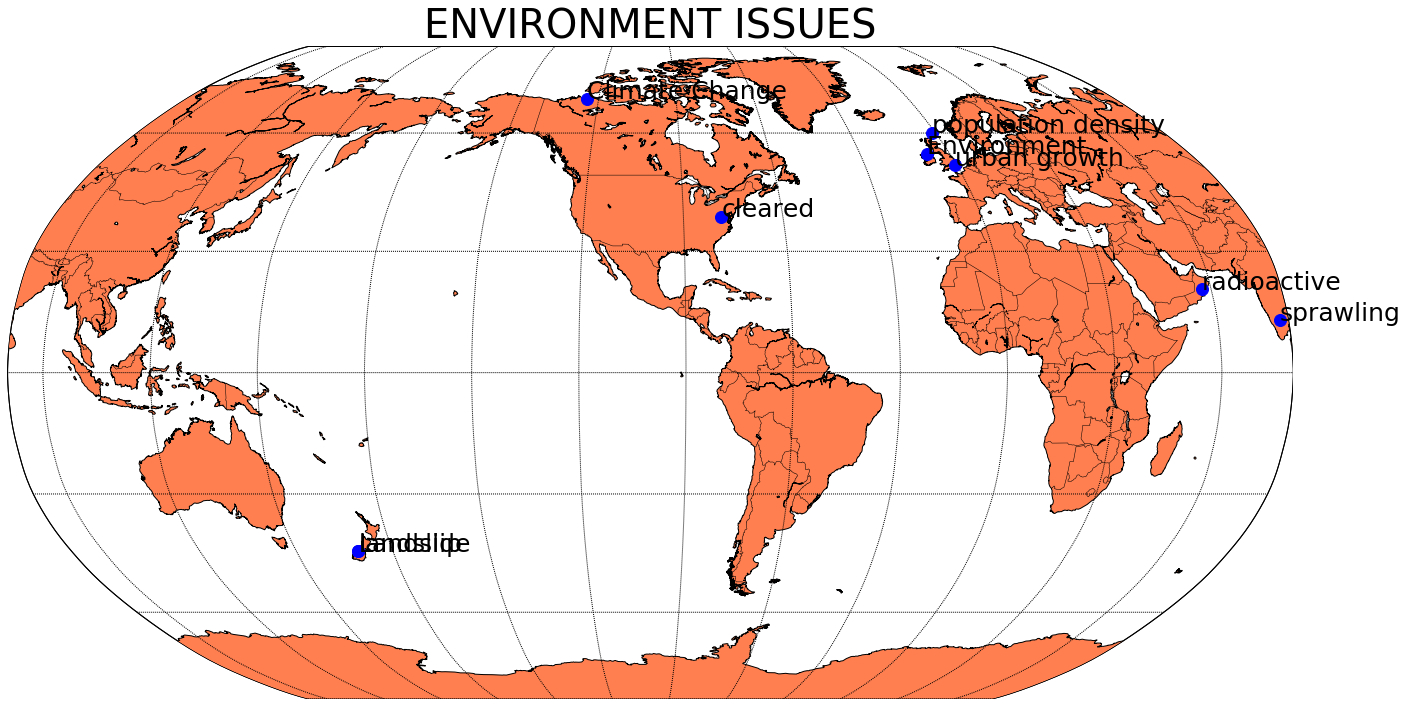

In [211]:
import matplotlib.pyplot as plt
import numpy as np
 
# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1
plt.figure(figsize=(24,12))
my_map = Basemap(projection='robin', lat_0=0, lon_0=-100,
              resolution='l', area_thresh=2000.0)
 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color='coral')
my_map.drawmapboundary()
 
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))


x,y = my_map(lonss, latss)
my_map.plot(x, y, 'bo', markersize=12)


for label, xpt, ypt in zip(labels, x, y):
    plt.text(xpt, ypt, label,fontsize=25)
title_string = "ENVIRONMENT ISSUES"

plt.title(title_string, fontsize=40) 
plt.show()

### Comparativa de Spotlight y Keyword.

##### El fichero xml a leer es enwiki-latest-pages-articles26xml-p42567203p42663461.xml

In [ ]:
from lxml import etree
import csv
import wikitextparser as wtp
import re
import json
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import urllib.parse
import pandas as pd

import requests
from IPython.core.display import display, HTML
# An API Error Exception
class APIError(Exception):
    def __init__(self, status):
        self.status = status
    def __str__(self):
        return "APIError: status={}".format(self.status)

lista = []
all_title = []
all_urls = []
all_texts = []
all_words = []

global D 
class WikiLinkTextProcessor:

    def __init__(self, input_xml):
        self.input_xml = input_xml
        self.wikilinks = {} # key is wikilink text, value is set of stringified Wikilink objects
    

    @staticmethod
    def stringify_wikilink(title, wikilink):
      
        wikilink = title + "@" + wikilink.title + "|" + wikilink.string
      
          
        wikilink = wikilink.strip()
        wikilink = re.sub(r"[#\|]$","",wikilink)
        return  wikilink

    def add_text_link(self,title,text,wikilink):
        if text is None or re.match(r"^\s*$",text):
            return
        text = re.sub(r"\s+"," ",text).strip()
        if text not in self.wikilinks:
            self.wikilinks[text] = set()
        self.wikilinks[text].add(WikiLinkTextProcessor.stringify_wikilink(title, wikilink))
    

    def set_wikilinks(self):
        tree = etree.parse(self.input_xml)
        root = tree.getroot()
       
        #print(root.findall(".//title"))
        # iterate through all the text
        for page in root.findall(".//page", namespaces=root.nsmap):
            title = page.findall(".//title", namespaces=page.nsmap)
            title = title[0].text
            #print(page)
            for text in page.findall(".//text", namespaces=page.nsmap):
                if text.text is None or len(text.text.strip())==0:
                    continue
                parsed = wtp.parse(text.text)
                #print(parsed)

                ## initial consts
                BASE_URL = 'http://api.dbpedia-spotlight.org/en/annotate?text={text}&confidence={confidence}&support={support}&sparql={sparql}'
                #print(BASE_URL)
                #print(type(section))
                #TEXT = open("/Users/prosy/.keras/datasets/enwiki-latest-pages-articles14.xml-p7697595p7744800","r",encoding='utf-8').read()
                
                TEXT = str(parsed)
                
                SPARQL = 'SELECT%20DISTINCT%20%3Fissue%20WHERE%20%7BVALUES%20%3Fissue%7B%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FDeforestation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FPollution%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FHuman_overpopulation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FBiocapacity%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FClimate_change%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FCarrying_capacity%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FIndustrialisation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FI_%3D_PAT%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FLand_degradation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FLand_reclamation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FOptimum_population%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FList_of_countries_and_territories_by_population_density%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FPopulation_dynamics%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FTotal_fertility_rate%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FUrbanization%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FWater_conflict%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FWater_scarcity%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FOverdrafting%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FTile_drainage%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FAgriculture%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FIntensive_farming%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FAgricultural_subsidy%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FIntensive_animal_farming%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FNutrient_pollution%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FOvergrazing%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FPesticide_drift%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FPlasticulture%3E%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FTile_drainage%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FBuilt_environment%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FDesertification%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FHabitat_fragmentation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FHabitat_destruction%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FLand_degradation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FTrail_ethics%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FUrban_heat_island%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FUrban_sprawl%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FNanotechnology%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FNuclear_fallout%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FNuclear_meltdown%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FRadioactive_decay%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FNuclear_safety_and_security%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FHigh-level_radioactive_waste_management%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FMonoculture%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FIrrigation%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FUrbanization%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FSwamp%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FLandslide%3E%20%3Chttp%3A%2F%2Fdbpedia.org%2Fresource%2FIndustrialisation%3E%20%20%20%20%20%7D%20%20%3Fissue%20%3Fa%20%3Fb%7D%20'
               
                CONFIDENCE = '0.2'
                SUPPORT = '20'
                REQUEST = BASE_URL.format(
                    text=urllib.parse.quote_plus(TEXT), 
                    confidence=CONFIDENCE, 
                    support=SUPPORT,
                    sparql=SPARQL
                )
                HEADERS = {'Accept': 'application/json'}
                
                r = requests.get(url=REQUEST, headers=HEADERS)
                if r.status_code == requests.codes['ok']:
                    response = r.json() 
                   
                    resources = response.get('Resources', [])
                    
                    
                    for res in resources:
                        
                        print("Parte del json")
                        print(response)
                        print("Parte del resources")
                        print(resources)
                        print("parte del res")
                        print(res)
                        print("03.....Parte de la URI y parte de surfaceForm")                                      
                        all_title.append(title)
                        all_words.append(res['@surfaceForm']) 
                        all_urls.append(res['@URI'])
                        all_texts.append(response['@text'])
                    df = pd.DataFrame(
                        {'titulo' : all_title,
                        'Palabra': all_words,
                        'Uri': all_urls,
                        'Texto': all_texts
                        })   

                    df = df.append(df)                     
            
                    df.to_csv(output_csv, index = False, header=True, sep="#", mode='a')
    
    def get_wikilinks(self):
        return self.wikilinks_counter, self.wikilinks
                            

from pathlib import Path
path_file = []
keras_home = '/Users/prosy/.keras/datasets/Run/'
#['salida_ner1.csv', 'salida_ner2.csv', 'salida_ner3.csv', 'salida_ner4.csv', 'salida_ner6.csv', 'salida_ner7.csv', 'salida_ner8.csv']
output_csv = 'C:/Users/Prosy/Documents/Master Ciencia de Datos/TFM/salida_ner0000000.csv'
def ls(ruta = Path.cwd()):
    return [arch.name for arch in Path(ruta).iterdir() if arch.is_file()]
path_file = ls(keras_home)
print("Listado de ficheros :")
print(path_file)
for path in path_file:
    input_xml = keras_home+path
    print("Comienza:" + path)
    processor = WikiLinkTextProcessor(input_xml)
    processor.set_wikilinks()

    print("Termina de leer: " + path)

Listado de ficheros :
['enwiki-latest-pages-articles26xml-p42567203p42663461.xml']
Comienza:enwiki-latest-pages-articles26xml-p42567203p42663461.xml
Parte del json
{'@text': '{{Infobox NRHP\n  | name = Magnolia\n  | nrhp_type = nrhp\n  | image = \n  | caption = \n  | nearest_city= [[Schriever, Louisiana]]\n | coordinates = {{coord|29|42|53|N|90|49|8|W|display=inline,title}}\n| locmapin = Louisiana#USA\n  | built = {{Start date|1855}}\n  | architecture = Greek Revival\n  | added = August 4, 1983\n  | area = {{convert|66|acre}}\n  | governing_body = Private \n  | refnum = 83000548<ref name="nris">{{NRISref|version=2010a}}</ref>\n}}\n\'\'\'Magnolia Plantation\'\'\', built in 1858, is a private residence located on [[Louisiana Highway 311]], west of [[New Orleans]] and {{convert|3|mi|km|0}} south of [[Schriever, Louisiana]]. The plantation was built to cultivate [[cotton]], which was a critical part of [[Terrebonne Parish, Louisiana|Terrebonne Parish]]\'s [[antebellum era|antebellum]] economy. The plantation house is one of six surviving [[Greek Revival architecture|Greek Revival]] plantation houses in the parish.<ref>{{cite web|title=Magnolia Plantation House|url=http://www.crt.state.la.us/dataprojects/hp/nhl/attachments/Parish55/Scans/55008001.pdf|publisher=Louisiana Division of Historic Preservation|accessdate=April 29, 2014}}</ref> A portion of the film \'\'12 Years a Slave\'\' was filmed at the plantation.<ref name="Mike Scott">{{cite web|last=Scott|first=Mike|title=Following in the real footsteps of "12 Years a Slave" figure Solomon Northrup: Mike\'s Movie Mailbag|url=http://www.nola.com/movies/index.ssf/2013/09/following_in_the_real-life_foo.html|work=journalist|publisher=NOLA.com/The Times-Picayune|accessdate=9 September 2013}}</ref>\n\nThe plantation was added to the [[National Register of Historic Places]] in 1983.<ref name="nris"/>\n\n==Further reading==\n* Menn, Joseph K. \'\'The Large Slaveholders of Louisiana &ndash; 1860\'\'. Gretna: Pelican Publishing Company, 1964.\n* Stahls, Paul F., Jr. \'\'Plantation Homes of the Lafourche Country\'\'. Gretna: Pelican Publishing Company, 1976.\n\n== References ==\n{{reflist}}\n\n[[Category:Houses on the National Register of Historic Places in Louisiana]]\n[[Category:Greek Revival houses in Louisiana]]\n[[Category:Houses completed in 1858]]\n[[Category:Houses in Terrebonne Parish, Louisiana]]\n[[Category:National Register of Historic Places in Terrebonne Parish, Louisiana]]', '@confidence': '0.2', '@support': '20', '@types': '', '@sparql': 'SELECT DISTINCT ?issue WHERE {VALUES ?issue{ <http://dbpedia.org/resource/Deforestation> <http://dbpedia.org/resource/Pollution> <http://dbpedia.org/resource/Human_overpopulation> <http://dbpedia.org/resource/Biocapacity> <http://dbpedia.org/resource/Climate_change> <http://dbpedia.org/resource/Carrying_capacity> <http://dbpedia.org/resource/Industrialisation> <http://dbpedia.org/resource/I_=_PAT> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Land_reclamation> <http://dbpedia.org/resource/Optimum_population> <http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density> <http://dbpedia.org/resource/Population_dynamics> <http://dbpedia.org/resource/Total_fertility_rate> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Water_conflict> <http://dbpedia.org/resource/Water_scarcity> <http://dbpedia.org/resource/Overdrafting> <http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Agriculture> <http://dbpedia.org/resource/Intensive_farming> <http://dbpedia.org/resource/Agricultural_subsidy> <http://dbpedia.org/resource/Intensive_animal_farming> <http://dbpedia.org/resource/Nutrient_pollution> <http://dbpedia.org/resource/Overgrazing> <http://dbpedia.org/resource/Pesticide_drift> <http://dbpedia.org/resource/Plasticulture><http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Built_environment> <http://dbpedia.org/resource/Desertification> <http://dbpedia.org/resource/Habitat_fragmentation> <http://dbpedia.org/resource/Habitat_destruction> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Trail_ethics> <http://dbpedia.org/resource/Urban_heat_island> <http://dbpedia.org/resource/Urban_sprawl> <http://dbpedia.org/resource/Nanotechnology> <http://dbpedia.org/resource/Nuclear_fallout> <http://dbpedia.org/resource/Nuclear_meltdown> <http://dbpedia.org/resource/Radioactive_decay> <http://dbpedia.org/resource/Nuclear_safety_and_security> <http://dbpedia.org/resource/High-level_radioactive_waste_management> <http://dbpedia.org/resource/Monoculture> <http://dbpedia.org/resource/Irrigation> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Swamp> <http://dbpedia.org/resource/Landslide> <http://dbpedia.org/resource/Industrialisation>     }  ?issue ?a ?b} ', '@policy': 'whitelist', 'Resources': [{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'cultivate', '@offset': '665', '@similarityScore': '0.867093515982102', '@percentageOfSecondRank': '0.1532744076872445'}]}
Parte del resources
[{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'cultivate', '@offset': '665', '@similarityScore': '0.867093515982102', '@percentageOfSecondRank': '0.1532744076872445'}]
parte del res
{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'cultivate', '@offset': '665', '@similarityScore': '0.867093515982102', '@percentageOfSecondRank': '0.1532744076872445'}
03.....Parte de la URI y parte de surfaceForm
Parte del json
{'@text': '<div style="float:left;margin-right:0.9em">\n[[File:Psittacosaurus mongoliensis whole BW.jpg|none|100px|Artist\'s restoration of \'\'Psittacosaurus mongoliensis \'\'.]]\n</div>\'\'\'\'\'Psittacosaurus\'\'\'\'\' ({{IPAc-en|ˌ|s|ɪ|t|ə|k|ə|ˈ|s|ɔr|ə|s}} {{respell|SIT|ə-kə|SOR|əs}}; from the [[Ancient Greek|Greek]] for "[[parrot]] [[lizard]]") is a [[genus]] of [[psittacosaurid]] [[ceratopsia]]n [[dinosaur]] from the Early [[Cretaceous]] [[Period (geology)|Period]] of what is now [[Asia]], between 124.2 to 100 [[million years ago]]. It is notable for being the most [[species]]-rich dinosaur genus. Nine to eleven species are recognized from [[fossil]]s found in different regions of modern-day China, Mongolia and Russia, with a possible additional species from Thailand.\n\nAll species of \'\'Psittacosaurus\'\' were [[gazelle]]-sized [[biped]]al [[herbivore]]s characterized by a high, powerful [[beak]] on the upper jaw. At least one species had long, quill-like structures on its tail and lower back, possibly serving a display function. Psittacosaurs were extremely early ceratopsians. Although they developed many novel adaptations, they shared many anatomical features with later ceratopsians such as \'\'[[Protoceratops]]\'\' and \'\'[[Triceratops]]\'\'.\n\n\'\'Psittacosaurus\'\' is not as familiar to the general public as its distant relative \'\'Triceratops\'\' but it is one of the most completely known dinosaur genera. Fossils of over 400 individuals have been collected so far, including many complete skeletons. Most different age classes are represented, from [[hatchling]] through to adult, which has allowed several detailed studies of \'\'Psittacosaurus\'\' growth rates and [[reproductive]] [[biology]]. The abundance of this dinosaur in the [[fossil record]] has led to the creation of the \'\'Psittacosaurus\'\' [[biochron]] for Lower Cretaceous sediments of [[east Asia]]. (\'\'\'[[Psittacosaurus|see more...]]\'\'\')', '@confidence': '0.2', '@support': '20', '@types': '', '@sparql': 'SELECT DISTINCT ?issue WHERE {VALUES ?issue{ <http://dbpedia.org/resource/Deforestation> <http://dbpedia.org/resource/Pollution> <http://dbpedia.org/resource/Human_overpopulation> <http://dbpedia.org/resource/Biocapacity> <http://dbpedia.org/resource/Climate_change> <http://dbpedia.org/resource/Carrying_capacity> <http://dbpedia.org/resource/Industrialisation> <http://dbpedia.org/resource/I_=_PAT> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Land_reclamation> <http://dbpedia.org/resource/Optimum_population> <http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density> <http://dbpedia.org/resource/Population_dynamics> <http://dbpedia.org/resource/Total_fertility_rate> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Water_conflict> <http://dbpedia.org/resource/Water_scarcity> <http://dbpedia.org/resource/Overdrafting> <http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Agriculture> <http://dbpedia.org/resource/Intensive_farming> <http://dbpedia.org/resource/Agricultural_subsidy> <http://dbpedia.org/resource/Intensive_animal_farming> <http://dbpedia.org/resource/Nutrient_pollution> <http://dbpedia.org/resource/Overgrazing> <http://dbpedia.org/resource/Pesticide_drift> <http://dbpedia.org/resource/Plasticulture><http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Built_environment> <http://dbpedia.org/resource/Desertification> <http://dbpedia.org/resource/Habitat_fragmentation> <http://dbpedia.org/resource/Habitat_destruction> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Trail_ethics> <http://dbpedia.org/resource/Urban_heat_island> <http://dbpedia.org/resource/Urban_sprawl> <http://dbpedia.org/resource/Nanotechnology> <http://dbpedia.org/resource/Nuclear_fallout> <http://dbpedia.org/resource/Nuclear_meltdown> <http://dbpedia.org/resource/Radioactive_decay> <http://dbpedia.org/resource/Nuclear_safety_and_security> <http://dbpedia.org/resource/High-level_radioactive_waste_management> <http://dbpedia.org/resource/Monoculture> <http://dbpedia.org/resource/Irrigation> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Swamp> <http://dbpedia.org/resource/Landslide> <http://dbpedia.org/resource/Industrialisation>     }  ?issue ?a ?b} ', '@policy': 'whitelist', 'Resources': [{'@URI': 'http://dbpedia.org/resource/Total_fertility_rate', '@support': '764', '@types': '', '@surfaceForm': 'rates', '@offset': '1642', '@similarityScore': '0.877541475565895', '@percentageOfSecondRank': '0.0893239067984813'}]}
Parte del resources
[{'@URI': 'http://dbpedia.org/resource/Total_fertility_rate', '@support': '764', '@types': '', '@surfaceForm': 'rates', '@offset': '1642', '@similarityScore': '0.877541475565895', '@percentageOfSecondRank': '0.0893239067984813'}]
parte del res
{'@URI': 'http://dbpedia.org/resource/Total_fertility_rate', '@support': '764', '@types': '', '@surfaceForm': 'rates', '@offset': '1642', '@similarityScore': '0.877541475565895', '@percentageOfSecondRank': '0.0893239067984813'}
03.....Parte de la URI y parte de surfaceForm
Parte del json
{'@text': "{{Infobox ethnic group|\n|group   = Zabolotnie Tatars <br> Сас сыбырлар, Sas sybyrlar\n|image   =\n|region1 = {{flag|Russia}}\n|pop1    = ca. 1800<ref>{{cite journal|last=Бакиева|first=Г.Т.|author2=Квашнин Ю.Н.|script-title=ru:К вопросу о тугумах у «заболотных» татар|url=http://www.ipdn.ru/rics/doc0/ZQ/labetno/pub/Bakieva_Kvashnin_K_voprosu_o_tugumah.pdf|accessdate=28 April 2014|language=ru}}</ref> \n|languages = [[Siberian Tatar language|Siberian Tatar]], [[Russian language|Russian]]\n|religions = [[Islam|Sunni Islam]]\n|related   =\n}}\n\n'''Zabolotnie Tatars''' ([[Siberian Tatar language|Siberian Tatar]]: ''сас татарлар''; ''Sas tatarlar'') are a subgroup of the [[Siberian Tatars]]. They live in the North-West parts of the [[Tobolsky District]], [[Tyumen Oblast]].\n\n==Origins==\n\nThey are considered to be the descendants of the [[Samoyedic peoples|Samoyedic]] and [[Ugrian peoples|Ugrian]] peoples of the [[West Siberian Plain]] – the [[Nenets people|Nenets]], [[Khanty people|Khanty]] and [[Mansi people|Mansi]] – who adopted [[Siberian Tatar language]] and [[converted to Islam]], while also preserving some elements of their traditional beliefs. \n\nTheir traditional areas of settlement are separated from [[Tobolsk]], the Russian and Siberian Tatar settlements by [[Irtysh River]], by impassable [[swamps]] which is the reason for their name in the Russian language (literally, ''[[Tatars]] who live behind the swamps''). This separation also helped them to preserve some elements of their traditional culture, which has been lost by other Siberian groups.<ref>{{cite web|last=Рассказов|first=С.В.|script-title=ru:Тобольск в шести приближениях|url=http://geo.1september.ru/article.php?ID=200104404|accessdate=28 April 2014|language=ru}}</ref>\n\n==References==\n{{Reflist}}\n\n\n[[Category:Siberian Tatars]]\n[[Category:Tyumen Oblast]]", '@confidence': '0.2', '@support': '20', '@types': '', '@sparql': 'SELECT DISTINCT ?issue WHERE {VALUES ?issue{ <http://dbpedia.org/resource/Deforestation> <http://dbpedia.org/resource/Pollution> <http://dbpedia.org/resource/Human_overpopulation> <http://dbpedia.org/resource/Biocapacity> <http://dbpedia.org/resource/Climate_change> <http://dbpedia.org/resource/Carrying_capacity> <http://dbpedia.org/resource/Industrialisation> <http://dbpedia.org/resource/I_=_PAT> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Land_reclamation> <http://dbpedia.org/resource/Optimum_population> <http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density> <http://dbpedia.org/resource/Population_dynamics> <http://dbpedia.org/resource/Total_fertility_rate> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Water_conflict> <http://dbpedia.org/resource/Water_scarcity> <http://dbpedia.org/resource/Overdrafting> <http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Agriculture> <http://dbpedia.org/resource/Intensive_farming> <http://dbpedia.org/resource/Agricultural_subsidy> <http://dbpedia.org/resource/Intensive_animal_farming> <http://dbpedia.org/resource/Nutrient_pollution> <http://dbpedia.org/resource/Overgrazing> <http://dbpedia.org/resource/Pesticide_drift> <http://dbpedia.org/resource/Plasticulture><http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Built_environment> <http://dbpedia.org/resource/Desertification> <http://dbpedia.org/resource/Habitat_fragmentation> <http://dbpedia.org/resource/Habitat_destruction> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Trail_ethics> <http://dbpedia.org/resource/Urban_heat_island> <http://dbpedia.org/resource/Urban_sprawl> <http://dbpedia.org/resource/Nanotechnology> <http://dbpedia.org/resource/Nuclear_fallout> <http://dbpedia.org/resource/Nuclear_meltdown> <http://dbpedia.org/resource/Radioactive_decay> <http://dbpedia.org/resource/Nuclear_safety_and_security> <http://dbpedia.org/resource/High-level_radioactive_waste_management> <http://dbpedia.org/resource/Monoculture> <http://dbpedia.org/resource/Irrigation> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Swamp> <http://dbpedia.org/resource/Landslide> <http://dbpedia.org/resource/Industrialisation>     }  ?issue ?a ?b} ', '@policy': 'whitelist', 'Resources': [{'@URI': 'http://dbpedia.org/resource/Swamp', '@support': '3467', '@types': '', '@surfaceForm': 'swamps', '@offset': '1304', '@similarityScore': '1.0', '@percentageOfSecondRank': '0.0'}, {'@URI': 'http://dbpedia.org/resource/Swamp', '@support': '3467', '@types': '', '@surfaceForm': 'swamps', '@offset': '1417', '@similarityScore': '1.0', '@percentageOfSecondRank': '0.0'}]}
Parte del resources
[{'@URI': 'http://dbpedia.org/resource/Swamp', '@support': '3467', '@types': '', '@surfaceForm': 'swamps', '@offset': '1304', '@similarityScore': '1.0', '@percentageOfSecondRank': '0.0'}, {'@URI': 'http://dbpedia.org/resource/Swamp', '@support': '3467', '@types': '', '@surfaceForm': 'swamps', '@offset': '1417', '@similarityScore': '1.0', '@percentageOfSecondRank': '0.0'}]
parte del res
{'@URI': 'http://dbpedia.org/resource/Swamp', '@support': '3467', '@types': '', '@surfaceForm': 'swamps', '@offset': '1304', '@similarityScore': '1.0', '@percentageOfSecondRank': '0.0'}
03.....Parte de la URI y parte de surfaceForm
Parte del json
{'@text': "{{Infobox ethnic group|\n|group   = Zabolotnie Tatars <br> Сас сыбырлар, Sas sybyrlar\n|image   =\n|region1 = {{flag|Russia}}\n|pop1    = ca. 1800<ref>{{cite journal|last=Бакиева|first=Г.Т.|author2=Квашнин Ю.Н.|script-title=ru:К вопросу о тугумах у «заболотных» татар|url=http://www.ipdn.ru/rics/doc0/ZQ/labetno/pub/Bakieva_Kvashnin_K_voprosu_o_tugumah.pdf|accessdate=28 April 2014|language=ru}}</ref> \n|languages = [[Siberian Tatar language|Siberian Tatar]], [[Russian language|Russian]]\n|religions = [[Islam|Sunni Islam]]\n|related   =\n}}\n\n'''Zabolotnie Tatars''' ([[Siberian Tatar language|Siberian Tatar]]: ''сас татарлар''; ''Sas tatarlar'') are a subgroup of the [[Siberian Tatars]]. They live in the North-West parts of the [[Tobolsky District]], [[Tyumen Oblast]].\n\n==Origins==\n\nThey are considered to be the descendants of the [[Samoyedic peoples|Samoyedic]] and [[Ugrian peoples|Ugrian]] peoples of the [[West Siberian Plain]] – the [[Nenets people|Nenets]], [[Khanty people|Khanty]] and [[Mansi people|Mansi]] – who adopted [[Siberian Tatar language]] and [[converted to Islam]], while also preserving some elements of their traditional beliefs. \n\nTheir traditional areas of settlement are separated from [[Tobolsk]], the Russian and Siberian Tatar settlements by [[Irtysh River]], by impassable [[swamps]] which is the reason for their name in the Russian language (literally, ''[[Tatars]] who live behind the swamps''). This separation also helped them to preserve some elements of their traditional culture, which has been lost by other Siberian groups.<ref>{{cite web|last=Рассказов|first=С.В.|script-title=ru:Тобольск в шести приближениях|url=http://geo.1september.ru/article.php?ID=200104404|accessdate=28 April 2014|language=ru}}</ref>\n\n==References==\n{{Reflist}}\n\n\n[[Category:Siberian Tatars]]\n[[Category:Tyumen Oblast]]", '@confidence': '0.2', '@support': '20', '@types': '', '@sparql': 'SELECT DISTINCT ?issue WHERE {VALUES ?issue{ <http://dbpedia.org/resource/Deforestation> <http://dbpedia.org/resource/Pollution> <http://dbpedia.org/resource/Human_overpopulation> <http://dbpedia.org/resource/Biocapacity> <http://dbpedia.org/resource/Climate_change> <http://dbpedia.org/resource/Carrying_capacity> <http://dbpedia.org/resource/Industrialisation> <http://dbpedia.org/resource/I_=_PAT> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Land_reclamation> <http://dbpedia.org/resource/Optimum_population> <http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density> <http://dbpedia.org/resource/Population_dynamics> <http://dbpedia.org/resource/Total_fertility_rate> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Water_conflict> <http://dbpedia.org/resource/Water_scarcity> <http://dbpedia.org/resource/Overdrafting> <http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Agriculture> <http://dbpedia.org/resource/Intensive_farming> <http://dbpedia.org/resource/Agricultural_subsidy> <http://dbpedia.org/resource/Intensive_animal_farming> <http://dbpedia.org/resource/Nutrient_pollution> <http://dbpedia.org/resource/Overgrazing> <http://dbpedia.org/resource/Pesticide_drift> <http://dbpedia.org/resource/Plasticulture><http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Built_environment> <http://dbpedia.org/resource/Desertification> <http://dbpedia.org/resource/Habitat_fragmentation> <http://dbpedia.org/resource/Habitat_destruction> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Trail_ethics> <http://dbpedia.org/resource/Urban_heat_island> <http://dbpedia.org/resource/Urban_sprawl> <http://dbpedia.org/resource/Nanotechnology> <http://dbpedia.org/resource/Nuclear_fallout> <http://dbpedia.org/resource/Nuclear_meltdown> <http://dbpedia.org/resource/Radioactive_decay> <http://dbpedia.org/resource/Nuclear_safety_and_security> <http://dbpedia.org/resource/High-level_radioactive_waste_management> <http://dbpedia.org/resource/Monoculture> <http://dbpedia.org/resource/Irrigation> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Swamp> <http://dbpedia.org/resource/Landslide> <http://dbpedia.org/resource/Industrialisation>     }  ?issue ?a ?b} ', '@policy': 'whitelist', 'Resources': [{'@URI': 'http://dbpedia.org/resource/Swamp', '@support': '3467', '@types': '', '@surfaceForm': 'swamps', '@offset': '1304', '@similarityScore': '1.0', '@percentageOfSecondRank': '0.0'}, {'@URI': 'http://dbpedia.org/resource/Swamp', '@support': '3467', '@types': '', '@surfaceForm': 'swamps', '@offset': '1417', '@similarityScore': '1.0', '@percentageOfSecondRank': '0.0'}]}
Parte del resources
[{'@URI': 'http://dbpedia.org/resource/Swamp', '@support': '3467', '@types': '', '@surfaceForm': 'swamps', '@offset': '1304', '@similarityScore': '1.0', '@percentageOfSecondRank': '0.0'}, {'@URI': 'http://dbpedia.org/resource/Swamp', '@support': '3467', '@types': '', '@surfaceForm': 'swamps', '@offset': '1417', '@similarityScore': '1.0', '@percentageOfSecondRank': '0.0'}]
parte del res
{'@URI': 'http://dbpedia.org/resource/Swamp', '@support': '3467', '@types': '', '@surfaceForm': 'swamps', '@offset': '1417', '@similarityScore': '1.0', '@percentageOfSecondRank': '0.0'}
03.....Parte de la URI y parte de surfaceForm
Parte del json
{'@text': '{{Politics of the Falkland Islands}}\nThe \'\'\'Falkland Islands general election of 1960\'\'\' was held on 24 and 25 March 1960 to elect members to the [[Legislative Council of the Falkland Islands|Legislative Council]]. Four out of the twelve Councillors were elected through [[universal suffrage]], two from [[Stanley (constituency)|Stanley]] and one each from [[East Falkland (constituency)|East Falkland]] and [[West Falkland (constituency)|West Falkland]]. The Legislative Council was intended to be dissolved on 29 February 1960 but to suit farming arrangements it was dissolved almost two months early, on 2 January.\n\n==Results==\nCandidates in \'\'\'bold\'\'\' were elected.  Candidates in \'\'italic\'\' were incumbents.\n=== Stanley constituency ===\n{{Election box begin for list| title= [[Stanley (constituency)|Stanley result]]<ref name="Gazette">{{cite web |title=FI Gazette 1968 |author= |url= |publisher=[[Jane Cameron National Archives]] |date=1968}}</ref>}}\n{{Election box candidate with party link|\n  |party      = Nonpartisan\n  |candidate  = \'\'\'\'\'Arthur Leslie Hardy\'\'\'\'\' [[File:Symbol confirmed.svg|16px]]\n  |votes      = \'\'uncontested\'\'\n  |percentage = N/A\n  |change     = N/A\n}}\n\n{{Election box candidate with party link|\n  |party      = Nonpartisan\n  |candidate  = \'\'\'Richard Victor Goss\'\'\' [[File:Symbol confirmed.svg|16px]]\n  |votes      = \'\'uncontested\'\'\n  |percentage = N/A\n  |change     = N/A\n}}\n{{Election box end}}\n\n=== East Falkland constituency ===\n{{Election box begin for list| title= [[East Falkland (constituency)|East Falkland]]<ref name="Gazette"/>}}\n{{Election box candidate with party link|\n  |party      = Nonpartisan\n  |candidate  = \'\'\'George Christopher Reginald Bonner\'\'\' [[File:Symbol confirmed.svg|16px]]\n  |votes      = \'\'uncontested\'\'\n  |percentage = N/A\n  |change     = N/A\n}}\n{{Election box end}}\n\n=== West Falkland constituency ===\n{{Election box begin for list| title= [[West Falkland (constituency)|West Falkland]]<ref name="Gazette"/>}}\n{{Election box candidate with party link|\n  |party      = Nonpartisan\n  |candidate  = \'\'\'Lewis Arnold Charles Bedford\'\'\' [[File:Symbol confirmed.svg|16px]]\n  |votes      = \'\'\'75\'\'\'\n  |percentage = 39.1\n  |change     = N/A\n}}\n\n{{Election box candidate with party link|\n  |party      = Nonpartisan\n  |candidate  = James Blyth\n  |votes      = 61\n  |percentage = 31.8\n  |change     = N/A\n}}\n\n{{Election box candidate with party link|\n  |party      = Nonpartisan\n  |candidate  = Stanley Frank Miller\n  |votes      = 56\n  |percentage = 29.2\n  |change     = N/A\n}}\n\n{{Election box turnout\n  |votes      = 192\n  |percentage = \n  |change     = \n}}\n{{Election box end}}\n\n==References==\n{{Reflist}}\n\n{{Falkland Islands elections}}\n\n[[Category:1960 elections in South America|Falkland Islands]]\n[[Category:Elections in the Falkland Islands|1960]]\n[[Category:1960 in the Falkland Islands|General election]]\n[[Category:Non-partisan elections]]\n[[Category:March 1960 events]]', '@confidence': '0.2', '@support': '20', '@types': '', '@sparql': 'SELECT DISTINCT ?issue WHERE {VALUES ?issue{ <http://dbpedia.org/resource/Deforestation> <http://dbpedia.org/resource/Pollution> <http://dbpedia.org/resource/Human_overpopulation> <http://dbpedia.org/resource/Biocapacity> <http://dbpedia.org/resource/Climate_change> <http://dbpedia.org/resource/Carrying_capacity> <http://dbpedia.org/resource/Industrialisation> <http://dbpedia.org/resource/I_=_PAT> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Land_reclamation> <http://dbpedia.org/resource/Optimum_population> <http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density> <http://dbpedia.org/resource/Population_dynamics> <http://dbpedia.org/resource/Total_fertility_rate> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Water_conflict> <http://dbpedia.org/resource/Water_scarcity> <http://dbpedia.org/resource/Overdrafting> <http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Agriculture> <http://dbpedia.org/resource/Intensive_farming> <http://dbpedia.org/resource/Agricultural_subsidy> <http://dbpedia.org/resource/Intensive_animal_farming> <http://dbpedia.org/resource/Nutrient_pollution> <http://dbpedia.org/resource/Overgrazing> <http://dbpedia.org/resource/Pesticide_drift> <http://dbpedia.org/resource/Plasticulture><http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Built_environment> <http://dbpedia.org/resource/Desertification> <http://dbpedia.org/resource/Habitat_fragmentation> <http://dbpedia.org/resource/Habitat_destruction> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Trail_ethics> <http://dbpedia.org/resource/Urban_heat_island> <http://dbpedia.org/resource/Urban_sprawl> <http://dbpedia.org/resource/Nanotechnology> <http://dbpedia.org/resource/Nuclear_fallout> <http://dbpedia.org/resource/Nuclear_meltdown> <http://dbpedia.org/resource/Radioactive_decay> <http://dbpedia.org/resource/Nuclear_safety_and_security> <http://dbpedia.org/resource/High-level_radioactive_waste_management> <http://dbpedia.org/resource/Monoculture> <http://dbpedia.org/resource/Irrigation> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Swamp> <http://dbpedia.org/resource/Landslide> <http://dbpedia.org/resource/Industrialisation>     }  ?issue ?a ?b} ', '@policy': 'whitelist', 'Resources': [{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'farming', '@offset': '541', '@similarityScore': '0.8580872489286419', '@percentageOfSecondRank': '0.14075304567547317'}]}
Parte del resources
[{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'farming', '@offset': '541', '@similarityScore': '0.8580872489286419', '@percentageOfSecondRank': '0.14075304567547317'}]
parte del res
{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'farming', '@offset': '541', '@similarityScore': '0.8580872489286419', '@percentageOfSecondRank': '0.14075304567547317'}
03.....Parte de la URI y parte de surfaceForm
Parte del json
{'@text': "{{short description|Mexican general}}\n{{Unreferenced|date=June 2019|bot=noref (GreenC bot)}}\n'''Guillen Genevevo Rivas''' (1886&ndash;1947) was a Mexican general and provisional Governor of [[San Luis Potosi]].\n\n==Origin==\n\nRivas was born in [[Rayon, San Luis Potosí]] in 1886. He joined the revolutionary forces and participated in the [[Mexican Revolution]] beginning in 1910, under the command of General [[Alberto Carrera Torres]], where he was ranked lieutenant.\n\n==[[Battle of Carrizal]]==\n\nOn June 21, 1916, during the [[Pancho Villa Expedition|Punitive Expedition]], a column of the U.S. Army under the command of Captain [[Charles T. Boyd]] were marching towards [[Rancho Santo Domingo]] from [[Villa Ahumada, Chihuahua]], overstepped the geographic limits granted to the Americans when the Mexican government of [[Venustiano Carranza]] approved the expedition. Lieutenant Rivas's forces, at the garrison at the nearby town of Carrizal, moved to block them and request their return to the authorized area. Captain Boyd refused, claiming he was pursuing an Army deserter. Rivas requested help from his superior,  requesting their return, so Captain Boyd refused, and warned that going after a U.S. army deserter, requesting the presence of his superior, General [[Félix Gómez]]. Gómez supported his subordinate, starting a battle in which General Gómez died, with Rivas in command. Lieutenant Rivas defeated the Americans and forced them to retreat.\n\nU.S. casualties were 50 soldiers killed, along with the capture of 27 prisoners, 22 horses and weapons; Mexico lost only 27 men, and 39 soldiers were wounded. In 1924, he received the Heroic Valor Award.\n\n==Later years==\nAs commander of Military Zone XIV, he fought against the Cristeros during the [[Cristero War]] in the states of [[Jalisco]] and [[San Luis Potosi]]; he was then promoted to brigadier general in 1938 after he fought against the rebellion of General [[Saturnino Cedillo]].\n\nHe became governor of his state and military commander of the states of [[Querétaro]], [[Oaxaca]] and [[Sonora]]. Subsequently, to retire from the army, he devoted himself to agriculture. Rivas died of drowning in [[Potrero de Para, San Luis Potosi]], in 1947.\n\n{{DEFAULTSORT:Guillen, Genovevo Rivas}}\n[[Category:1886 births]]\n[[Category:1947 deaths]]\n[[Category:Governors of San Luis Potosí]]\n[[Category:Mexican generals]]", '@confidence': '0.2', '@support': '20', '@types': '', '@sparql': 'SELECT DISTINCT ?issue WHERE {VALUES ?issue{ <http://dbpedia.org/resource/Deforestation> <http://dbpedia.org/resource/Pollution> <http://dbpedia.org/resource/Human_overpopulation> <http://dbpedia.org/resource/Biocapacity> <http://dbpedia.org/resource/Climate_change> <http://dbpedia.org/resource/Carrying_capacity> <http://dbpedia.org/resource/Industrialisation> <http://dbpedia.org/resource/I_=_PAT> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Land_reclamation> <http://dbpedia.org/resource/Optimum_population> <http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density> <http://dbpedia.org/resource/Population_dynamics> <http://dbpedia.org/resource/Total_fertility_rate> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Water_conflict> <http://dbpedia.org/resource/Water_scarcity> <http://dbpedia.org/resource/Overdrafting> <http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Agriculture> <http://dbpedia.org/resource/Intensive_farming> <http://dbpedia.org/resource/Agricultural_subsidy> <http://dbpedia.org/resource/Intensive_animal_farming> <http://dbpedia.org/resource/Nutrient_pollution> <http://dbpedia.org/resource/Overgrazing> <http://dbpedia.org/resource/Pesticide_drift> <http://dbpedia.org/resource/Plasticulture><http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Built_environment> <http://dbpedia.org/resource/Desertification> <http://dbpedia.org/resource/Habitat_fragmentation> <http://dbpedia.org/resource/Habitat_destruction> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Trail_ethics> <http://dbpedia.org/resource/Urban_heat_island> <http://dbpedia.org/resource/Urban_sprawl> <http://dbpedia.org/resource/Nanotechnology> <http://dbpedia.org/resource/Nuclear_fallout> <http://dbpedia.org/resource/Nuclear_meltdown> <http://dbpedia.org/resource/Radioactive_decay> <http://dbpedia.org/resource/Nuclear_safety_and_security> <http://dbpedia.org/resource/High-level_radioactive_waste_management> <http://dbpedia.org/resource/Monoculture> <http://dbpedia.org/resource/Irrigation> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Swamp> <http://dbpedia.org/resource/Landslide> <http://dbpedia.org/resource/Industrialisation>     }  ?issue ?a ?b} ', '@policy': 'whitelist', 'Resources': [{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'agriculture', '@offset': '2127', '@similarityScore': '0.9990390719901006', '@percentageOfSecondRank': '8.825280519291894E-4'}]}
Parte del resources
[{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'agriculture', '@offset': '2127', '@similarityScore': '0.9990390719901006', '@percentageOfSecondRank': '8.825280519291894E-4'}]
parte del res
{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'agriculture', '@offset': '2127', '@similarityScore': '0.9990390719901006', '@percentageOfSecondRank': '8.825280519291894E-4'}
03.....Parte de la URI y parte de surfaceForm
Parte del json
{'@text': "{{Use Australian English|date=May 2014}}\n{{Use dmy dates|date=May 2014}}\n{{Location map|Western Australia|label=Kooline\n  |position=top\n  |lat_deg=22.913|lat_dir=S\n  |lon_deg=116.289|lon_dir=E\n  |caption=Location in Western Australia}}\n{{coord|22.913|S|116.289|E|type:landmark_region:AU|name=Kooline|display=title}}\n\n'''Kooline Station''', often referred to as '''Kooline''', is a pastoral lease that operates as a [[cattle station]].\n\nIt is located about {{convert|140|km|mi|0}} south of [[Pannawonica, Western Australia|Pannawonica]] and  {{convert|200|km|mi|0}} south east of [[Onslow, Western Australia|Onslow]] in the [[Pilbara]] region of [[Western Australia]].\n\nKooline occupies an area of {{convert|2043|km2|sqmi|0}} with the [[Ashburton River (Western Australia)|Ashburton River]] running through the property for a distance of about {{convert|90|km|mi|0}}. The property shares boundaries with [[Ashburton Downs]], [[Glenflorrie]], [[Ullawarra]], [[Wyloo]] and Amelia Stations as well as vacant [[crown land]].<ref name=R1>{{cite web|url=http://archive.agric.wa.gov.au/objtwr/imported_assets/content/lwe/rpm/catman/62%20part%202.pdf|title=Station Reports|year=1980|accessdate=5 April 2014|publisher=[[Department of Agriculture and Food (Western Australia)|Department of Agriculture]]}}</ref>\n\nIn 1921 the property was owned by Mr Sanderson, Michael Corbett and his two brothers, who experienced a good season<ref>{{cite news |url=http://nla.gov.au/nla.news-article74956472 |title=Asburton |newspaper=[[The Northern Times]] |location=Carnarvon, Western Australia |date=26 March 1921 |accessdate=2 May 2014 |page=5 |via=National Library of Australia}}</ref> followed by a [[drought]] that broke in early 1923.<ref>{{cite news |url=http://nla.gov.au/nla.news-article23886013 |title=Rural Gossip |newspaper=[[The West Australian]] |location=Perth |date=29 January 1923 |accessdate=2 May 2014 |page=10 |via=National Library of Australia}}</ref>\n\n\n==See also==\n*[[List of ranches and stations]]\n\n==References==\n{{Reflist}}\n{{Stations of the Pilbara Western Australia}}\n\n[[Category:Pastoral leases in Western Australia]]\n[[Category:Stations (Australian agriculture)]]\n[[Category:Pilbara]]", '@confidence': '0.2', '@support': '20', '@types': '', '@sparql': 'SELECT DISTINCT ?issue WHERE {VALUES ?issue{ <http://dbpedia.org/resource/Deforestation> <http://dbpedia.org/resource/Pollution> <http://dbpedia.org/resource/Human_overpopulation> <http://dbpedia.org/resource/Biocapacity> <http://dbpedia.org/resource/Climate_change> <http://dbpedia.org/resource/Carrying_capacity> <http://dbpedia.org/resource/Industrialisation> <http://dbpedia.org/resource/I_=_PAT> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Land_reclamation> <http://dbpedia.org/resource/Optimum_population> <http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density> <http://dbpedia.org/resource/Population_dynamics> <http://dbpedia.org/resource/Total_fertility_rate> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Water_conflict> <http://dbpedia.org/resource/Water_scarcity> <http://dbpedia.org/resource/Overdrafting> <http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Agriculture> <http://dbpedia.org/resource/Intensive_farming> <http://dbpedia.org/resource/Agricultural_subsidy> <http://dbpedia.org/resource/Intensive_animal_farming> <http://dbpedia.org/resource/Nutrient_pollution> <http://dbpedia.org/resource/Overgrazing> <http://dbpedia.org/resource/Pesticide_drift> <http://dbpedia.org/resource/Plasticulture><http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Built_environment> <http://dbpedia.org/resource/Desertification> <http://dbpedia.org/resource/Habitat_fragmentation> <http://dbpedia.org/resource/Habitat_destruction> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Trail_ethics> <http://dbpedia.org/resource/Urban_heat_island> <http://dbpedia.org/resource/Urban_sprawl> <http://dbpedia.org/resource/Nanotechnology> <http://dbpedia.org/resource/Nuclear_fallout> <http://dbpedia.org/resource/Nuclear_meltdown> <http://dbpedia.org/resource/Radioactive_decay> <http://dbpedia.org/resource/Nuclear_safety_and_security> <http://dbpedia.org/resource/High-level_radioactive_waste_management> <http://dbpedia.org/resource/Monoculture> <http://dbpedia.org/resource/Irrigation> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Swamp> <http://dbpedia.org/resource/Landslide> <http://dbpedia.org/resource/Industrialisation>     }  ?issue ?a ?b} ', '@policy': 'whitelist', 'Resources': [{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'agriculture', '@offset': '2155', '@similarityScore': '0.9997868703001629', '@percentageOfSecondRank': '2.1283979903646217E-4'}]}
Parte del resources
[{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'agriculture', '@offset': '2155', '@similarityScore': '0.9997868703001629', '@percentageOfSecondRank': '2.1283979903646217E-4'}]
parte del res
{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'agriculture', '@offset': '2155', '@similarityScore': '0.9997868703001629', '@percentageOfSecondRank': '2.1283979903646217E-4'}
03.....Parte de la URI y parte de surfaceForm
Parte del json
{'@text': '{{Infobox NRHP\n  | name = Silver Lake Farm\n  | nrhp_type = \n  | image = HarrisvilleNH SilverLakeFarm.jpg\n  | caption = \n  | location= Between Silver Lake and Seaver Rds. near intersection with Old Nelson Rd., [[Harrisville, New Hampshire]]\n  | coordinates = {{coord|42|56|30|N|72|8|35|W|display=inline,title}}\n  | locmapin = New Hampshire#USA\n  | built = {{Start date|1820}}\n  | added = January 14, 1988\n  | area = less than one acre\n  | governing_body = Private \n  | mpsub = {{NRHP url|id=64000486|title=Harrisville MRA}}\n  | refnum = 86003252<ref name="nris">{{NRISref|version=2010a}}</ref>\n}}\nThe \'\'\'Silver Lake Farm\'\'\' is a historic farmstead on Seaver Road in northwestern [[Harrisville, New Hampshire]].  Established about 1820, it was a highly successful local farm, serving first businesses as far off as [[Keene, New Hampshire|Keene]], and then the local summer resort trade at nearby [[Silver Lake (Harrisville, New Hampshire)|Silver Lake]]. The house is relatively little-altered despite intensive use into the 20th century.  The farmstead was listed on the [[National Register of Historic Places]] in 1988.<ref name="nris"/>\n\n==Description and history==\nThe Silver Lake Farm is located in a rural setting west of Harrisville village, on the west side of Seaver Road south of Breed Road.  It is set high on a hillside, with fine views of the surrounding countryside, including the eponymous Silver Lake.  It consists of a traditional New England farm complex, with a clapboarded farmhouse that was built c. 1820, a poultry shed, two early 20th-century barns, and a modern tractor shed.\n\nThe farm was originally established by Paul Whitcomb Breed, whose family gave the lake its early name (Breed Pond).  It was later owned by the Farwells and Seavers, like the Breeds prominent Harrisville families.  Despite its active use until the 1970s, the farmhouse remained relatively unaltered, lacking even modern heating.  In addition to operating the farm, the Seavers also had a sawmill near the outlet of Silver Lake.  Their customers included businesses and residents of nearby communities, as well as the summer residents who came to populate the Silver Lake area around the turn of the 20th century.<ref name=NRHP>{{cite web|url={{NRHP url|id=86003252}}|title=NRHP nomination for Silver Lake Farm|publisher=National Park Service|accessdate=2014-05-02}}</ref>\n\n==See also==\n*[[Silver Lake District]]\n*[[National Register of Historic Places listings in Cheshire County, New Hampshire]]\n\n==References==\n{{reflist}}\n\n{{National Register of Historic Places in New Hampshire}}\n\n[[Category:Buildings and structures completed in 1820]]\n[[Category:Buildings and structures in Harrisville, New Hampshire]]\n[[Category:Farms in New Hampshire]]\n[[Category:Farms on the National Register of Historic Places in New Hampshire]]\n[[Category:National Register of Historic Places in Cheshire County, New Hampshire]]', '@confidence': '0.2', '@support': '20', '@types': '', '@sparql': 'SELECT DISTINCT ?issue WHERE {VALUES ?issue{ <http://dbpedia.org/resource/Deforestation> <http://dbpedia.org/resource/Pollution> <http://dbpedia.org/resource/Human_overpopulation> <http://dbpedia.org/resource/Biocapacity> <http://dbpedia.org/resource/Climate_change> <http://dbpedia.org/resource/Carrying_capacity> <http://dbpedia.org/resource/Industrialisation> <http://dbpedia.org/resource/I_=_PAT> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Land_reclamation> <http://dbpedia.org/resource/Optimum_population> <http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density> <http://dbpedia.org/resource/Population_dynamics> <http://dbpedia.org/resource/Total_fertility_rate> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Water_conflict> <http://dbpedia.org/resource/Water_scarcity> <http://dbpedia.org/resource/Overdrafting> <http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Agriculture> <http://dbpedia.org/resource/Intensive_farming> <http://dbpedia.org/resource/Agricultural_subsidy> <http://dbpedia.org/resource/Intensive_animal_farming> <http://dbpedia.org/resource/Nutrient_pollution> <http://dbpedia.org/resource/Overgrazing> <http://dbpedia.org/resource/Pesticide_drift> <http://dbpedia.org/resource/Plasticulture><http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Built_environment> <http://dbpedia.org/resource/Desertification> <http://dbpedia.org/resource/Habitat_fragmentation> <http://dbpedia.org/resource/Habitat_destruction> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Trail_ethics> <http://dbpedia.org/resource/Urban_heat_island> <http://dbpedia.org/resource/Urban_sprawl> <http://dbpedia.org/resource/Nanotechnology> <http://dbpedia.org/resource/Nuclear_fallout> <http://dbpedia.org/resource/Nuclear_meltdown> <http://dbpedia.org/resource/Radioactive_decay> <http://dbpedia.org/resource/Nuclear_safety_and_security> <http://dbpedia.org/resource/High-level_radioactive_waste_management> <http://dbpedia.org/resource/Monoculture> <http://dbpedia.org/resource/Irrigation> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Swamp> <http://dbpedia.org/resource/Landslide> <http://dbpedia.org/resource/Industrialisation>     }  ?issue ?a ?b} ', '@policy': 'whitelist', 'Resources': [{'@URI': 'http://dbpedia.org/resource/Intensive_farming', '@support': '492', '@types': '', '@surfaceForm': 'intensive', '@offset': '999', '@similarityScore': '0.9999999994977316', '@percentageOfSecondRank': '4.1106928198201497E-10'}]}
Parte del resources
[{'@URI': 'http://dbpedia.org/resource/Intensive_farming', '@support': '492', '@types': '', '@surfaceForm': 'intensive', '@offset': '999', '@similarityScore': '0.9999999994977316', '@percentageOfSecondRank': '4.1106928198201497E-10'}]
parte del res
{'@URI': 'http://dbpedia.org/resource/Intensive_farming', '@support': '492', '@types': '', '@surfaceForm': 'intensive', '@offset': '999', '@similarityScore': '0.9999999994977316', '@percentageOfSecondRank': '4.1106928198201497E-10'}
03.....Parte de la URI y parte de surfaceForm
Parte del json
{'@text': '{{Infobox\n|name         = Infobox/doc\n|bodystyle    = \n|title        = University of Maryland <br/> Baltimore County Campus\n|titlestyle   = background:#EF4135\n|image        = [[File:Giffen Hill.jpg|200 px]]\n|imagestyle   = \n|caption      = \n|captionstyle = \n|headerstyle  = background:#EF4135;\n|labelstyle   = background:#00000;\n|datastyle    = \n|header1 = Giffen Hill \n|label1  = \n|data1   = \n|header2 =\n|label2  = Dedicated\n|data2   = 1996\n|header3 =\n|label3  = Location\n|data3   = Hilltop Circle and Commons Drive<br/>[[Baltimore, Maryland]] 21250\n|header4 =\n|label4  = \n|data4   = \n|header5 =\n|label5  =\n|data5   = \n|header6 =\n|label6  =\n|data6   = \n|header7 =\n|label7  =\n|data7   = \n|date= \n|header8 =\n|label8  =\n|data8   = \n|header9 =\n|label9  =\n|data9   = \n|header10 =\n|label10  = \n|data10   = \n|header11 =\n|label11  =\n|data11   = \n|belowstyle = background:#EF4135;\n|below = \n}}\n\n\'\'\'Giffen Hill\'\'\' is a highpoint on the campus of the [[University of Maryland, Baltimore County]] in [[Arbutus, Maryland]], and is a historic site of the [[Manual Labor School for Indigent Boys]]. The hill is a gathering place near the [[UMBC Stadium]], and will be adjacent to the future site of the UMBC Events Center, planned to open in 2017.<ref>{{cite web|url=http://www.umbc.edu/fm/documents/UMBCSpringForum2014.pdf |title=Archived copy |accessdate=May 3, 2014 |url-status=dead |archiveurl=https://web.archive.org/web/20140503055108/http://www.umbc.edu/fm/documents/UMBCSpringForum2014.pdf |archivedate=May 3, 2014 }}</ref>\n\n==History==\n\nOriginally, the site was the location of the brick residence for the [[Manual Labor School for Indigent Boys]], constructed in 1860.<ref name="Marker">{{cite web|url=http://www.bcpl.info/sites/default/files/images/community/images/community-history-arbutus-plaque.jpg|title=Image of bronze marker|accessdate=April 25, 2016}}</ref> The school was also simply known as the Baltimore Farm School, due to agriculture being the main focus of curriculum. Numerous renowned Baltimoreans were involved with the school\'s operations, like [[Johns Hopkins]], and Gustav W. Lurman Jr. who both served on the school\'s board of directors. The Farm School operated from 1839 to 1922, until it was absorbed by the [[Spring Grove Hospital Center]], and then subsequently transferred to its present owner, the [[University of Maryland, Baltimore County]].<ref name="Marker" />\n\nIn May 1996, the Coalition for the Preservation of Southwestern Baltimore County, the Catonsville Historical Trust, and the Baltimore County Historical Trust dedicated the historical site.<ref name="Greenspaces">{{cite web|url=https://maps.google.com/maps/ms?ie=UTF8&oe=UTF8&msa=0&msid=208426867276218721859.0004e401e6c1e06f6272a&dg=feature|title=UMBC Greenspaces map|accessdate=April 25, 2016}}</ref> UMBC named the hill for Vice President Sallie Giffen.<ref name="Greenspaces" /> Historic [[white oak]] trees also occupy the historic hilltop.\n\n== External links ==\n* [http://explore.baltimoreheritage.org/items/show/552 Baltimore Manual Labor School – Explore Baltimore Heritage]\n\n==References==\n{{reflist}}\n\n{{UMBC}}\n\n[[Category:University of Maryland, Baltimore County]]', '@confidence': '0.2', '@support': '20', '@types': '', '@sparql': 'SELECT DISTINCT ?issue WHERE {VALUES ?issue{ <http://dbpedia.org/resource/Deforestation> <http://dbpedia.org/resource/Pollution> <http://dbpedia.org/resource/Human_overpopulation> <http://dbpedia.org/resource/Biocapacity> <http://dbpedia.org/resource/Climate_change> <http://dbpedia.org/resource/Carrying_capacity> <http://dbpedia.org/resource/Industrialisation> <http://dbpedia.org/resource/I_=_PAT> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Land_reclamation> <http://dbpedia.org/resource/Optimum_population> <http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density> <http://dbpedia.org/resource/Population_dynamics> <http://dbpedia.org/resource/Total_fertility_rate> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Water_conflict> <http://dbpedia.org/resource/Water_scarcity> <http://dbpedia.org/resource/Overdrafting> <http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Agriculture> <http://dbpedia.org/resource/Intensive_farming> <http://dbpedia.org/resource/Agricultural_subsidy> <http://dbpedia.org/resource/Intensive_animal_farming> <http://dbpedia.org/resource/Nutrient_pollution> <http://dbpedia.org/resource/Overgrazing> <http://dbpedia.org/resource/Pesticide_drift> <http://dbpedia.org/resource/Plasticulture><http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Built_environment> <http://dbpedia.org/resource/Desertification> <http://dbpedia.org/resource/Habitat_fragmentation> <http://dbpedia.org/resource/Habitat_destruction> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Trail_ethics> <http://dbpedia.org/resource/Urban_heat_island> <http://dbpedia.org/resource/Urban_sprawl> <http://dbpedia.org/resource/Nanotechnology> <http://dbpedia.org/resource/Nuclear_fallout> <http://dbpedia.org/resource/Nuclear_meltdown> <http://dbpedia.org/resource/Radioactive_decay> <http://dbpedia.org/resource/Nuclear_safety_and_security> <http://dbpedia.org/resource/High-level_radioactive_waste_management> <http://dbpedia.org/resource/Monoculture> <http://dbpedia.org/resource/Irrigation> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Swamp> <http://dbpedia.org/resource/Landslide> <http://dbpedia.org/resource/Industrialisation>     }  ?issue ?a ?b} ', '@policy': 'whitelist', 'Resources': [{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'agriculture', '@offset': '1933', '@similarityScore': '0.9997266544346811', '@percentageOfSecondRank': '2.728114151901334E-4'}]}
Parte del resources
[{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'agriculture', '@offset': '1933', '@similarityScore': '0.9997266544346811', '@percentageOfSecondRank': '2.728114151901334E-4'}]
parte del res
{'@URI': 'http://dbpedia.org/resource/Agriculture', '@support': '20612', '@types': '', '@surfaceForm': 'agriculture', '@offset': '1933', '@similarityScore': '0.9997266544346811', '@percentageOfSecondRank': '2.728114151901334E-4'}
03.....Parte de la URI y parte de surfaceForm
Parte del json
{'@text': '{{{{{1<noinclude>|show data</noinclude>}}}|Australia|{{{2|}}}|{{{3|}}}|{{{4|}}}|{{{5|}}}|type=country|continent=Australia (continent)|popbase=25500766|popbaseyear=2019|popbasemonth=10|popbaseday=25|popinc=1028.571|land area=7682300|total area=7692024|flag image=Flag of Australia.svg}}<noinclude>\n\n==Updates==\nDue to the precision used in the automatic calculation of the currently projected population, a rounding error occurs in the output and this needs to be compensated for periodically in order to reduce this error, or else the error will compound over time. This is most easily achieved by using the figures presented at the official population clock at 00:00 UTC on any day.\n\nThis template is used in a number of articles and these need to be checked and corrected as shown in the following table to ensure consistency:\n{| class="wikitable plainrowheaders" style="text-align:center; width:100%;"\n|-\n! scope="col" style="width:41%" | Article\n! scope="col" style="width:14%" | Area to be updated\n! scope="col" style="width:45%" | Details of update\n|-\n| scope="row" | [[Template:Data Australia]]\n| template data\n| style="text-align:left;" | popbase (population at 00:00 UTC), date and pop increase (86400 / rate = popinc)\n|-\n| scope="row" | [[Australia]]\n| infobox\n| style="text-align:left;" | citation access-date\n|-\n| scope="row" | [[Australia–New Zealand relations]]\n| table\n| style="text-align:left;" | citation access-date\n|-\n| scope="row" | [[Australia–United States relations]]\n| table\n| style="text-align:left;" | citation access-date\n|-\n| scope="row" | [[Demography of Australia]]\n| prose\n| style="text-align:left;" | citation access-date\n|-\n| scope="row" | [[List of countries and dependencies by population]]\n| {{N/a}}\n| style="text-align:left;" | Article should be checked to ensure template has not been removed\n|-\n| scope="row" | [[List of countries and dependencies by population density]]\n| {{N/a}}\n| style="text-align:left;" | Article should be checked to ensure template has not been removed\n|-\n| scope="row" | [[List of member states of the Commonwealth of Nations by population]]\n| {{N/a}}\n| style="text-align:left;" | Article should be checked to ensure template has not been removed\n|}\n\nFor consistency, it is recommended that the following edit summary be used when updating articles:\n::\'\'Australian population estimate has been updated based on current data at official population clock to compensate for rounding error\'\'\n\n==References==\n* [http://www.abs.gov.au/ausstats/abs%40.nsf/94713ad445ff1425ca25682000192af2/1647509ef7e25faaca2568a900154b63?OpenDocument Official Australian population clock]<ref>The referenced page states: "This projection is based on the estimated resident population at 30 June 2018 and assumes growth since then of ... an overall total population increase of one person every 1 minute and 15 seconds.</ref>\n</noinclude>', '@confidence': '0.2', '@support': '20', '@types': '', '@sparql': 'SELECT DISTINCT ?issue WHERE {VALUES ?issue{ <http://dbpedia.org/resource/Deforestation> <http://dbpedia.org/resource/Pollution> <http://dbpedia.org/resource/Human_overpopulation> <http://dbpedia.org/resource/Biocapacity> <http://dbpedia.org/resource/Climate_change> <http://dbpedia.org/resource/Carrying_capacity> <http://dbpedia.org/resource/Industrialisation> <http://dbpedia.org/resource/I_=_PAT> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Land_reclamation> <http://dbpedia.org/resource/Optimum_population> <http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density> <http://dbpedia.org/resource/Population_dynamics> <http://dbpedia.org/resource/Total_fertility_rate> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Water_conflict> <http://dbpedia.org/resource/Water_scarcity> <http://dbpedia.org/resource/Overdrafting> <http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Agriculture> <http://dbpedia.org/resource/Intensive_farming> <http://dbpedia.org/resource/Agricultural_subsidy> <http://dbpedia.org/resource/Intensive_animal_farming> <http://dbpedia.org/resource/Nutrient_pollution> <http://dbpedia.org/resource/Overgrazing> <http://dbpedia.org/resource/Pesticide_drift> <http://dbpedia.org/resource/Plasticulture><http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Built_environment> <http://dbpedia.org/resource/Desertification> <http://dbpedia.org/resource/Habitat_fragmentation> <http://dbpedia.org/resource/Habitat_destruction> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Trail_ethics> <http://dbpedia.org/resource/Urban_heat_island> <http://dbpedia.org/resource/Urban_sprawl> <http://dbpedia.org/resource/Nanotechnology> <http://dbpedia.org/resource/Nuclear_fallout> <http://dbpedia.org/resource/Nuclear_meltdown> <http://dbpedia.org/resource/Radioactive_decay> <http://dbpedia.org/resource/Nuclear_safety_and_security> <http://dbpedia.org/resource/High-level_radioactive_waste_management> <http://dbpedia.org/resource/Monoculture> <http://dbpedia.org/resource/Irrigation> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Swamp> <http://dbpedia.org/resource/Landslide> <http://dbpedia.org/resource/Industrialisation>     }  ?issue ?a ?b} ', '@policy': 'whitelist', 'Resources': [{'@URI': 'http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density', '@support': '122', '@types': '', '@surfaceForm': 'population density', '@offset': '1890', '@similarityScore': '0.9973407304353935', '@percentageOfSecondRank': '0.002560884643242552'}]}
Parte del resources
[{'@URI': 'http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density', '@support': '122', '@types': '', '@surfaceForm': 'population density', '@offset': '1890', '@similarityScore': '0.9973407304353935', '@percentageOfSecondRank': '0.002560884643242552'}]
parte del res
{'@URI': 'http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density', '@support': '122', '@types': '', '@surfaceForm': 'population density', '@offset': '1890', '@similarityScore': '0.9973407304353935', '@percentageOfSecondRank': '0.002560884643242552'}
03.....Parte de la URI y parte de surfaceForm
Parte del json
{'@text': '{{DISPLAYTITLE:\'\'N\'\',\'\'N\'\'-Dimethylethylamine}}\n{{chembox\n| Watchedfields = changed\n| verifiedrevid = 607448118\n| Name = \'\'N\'\',\'\'N\'\'-Dimethylethylamine\n| ImageFile = N,N-Dimethylethylamine.svg\n| ImageSize = \n| PIN = \'\'N\'\',\'\'N\'\'-Dimethyl ethyl amine\n| SystematicName = \n| OtherNames = Ethyl(dimethyl)amine\n| IUPACName = Dimethyl ethyl amine\n| Section1 = {{Chembox Identifiers\n| UNII = 9N5384XVEM\n| IUPHAR_ligand = 5523\n| CASNo_Ref = {{cascite|correct|??}}\n| CASNo=598-56-1\n| ChemSpiderID_Ref = {{chemspidercite|correct|chemspider}}\n| ChemSpiderID = 11230\n| PubChem=11723\n| SMILES=CCN(C)C\n  }}\n| Section2 = {{Chembox Properties\n| C=4 | H=11 | N=1\n| Appearance=Volatile liquid at room temp.\n| Density= 0.7±0.1 g/cm<sup>3</sup>\n| MeltingPtC=-140\n| BoilingPtC= 36.5\n| Solubility=\n| VaporPressure = 495.4±0.1 mmHg\n| pKa = 10.16 (for the conjugate acid) (H<sub>2</sub>O)<ref name=toxnet/>\n  }}\n| Section3 = {{Chembox Hazards\n| MainHazards=\n| FlashPt=\n| AutoignitionPt =\n  }}\n| Section4 = \n| Section5 = \n| Section6 = \n}}\n\n\'\'\'\'\'N\'\',\'\'N\'\'-Dimethylethylamine\'\'\' (\'\'\'DMEA\'\'\'), sometimes referred to as dimethylethylamine, is an [[organic compound]] with formula {{chemical formula|C|4|H|11|N}}. It is an industrial chemical that is mainly used in foundries as a catalyst for sand core production.<ref>{{cite web|title=Dimethylethylamine|url=http://www.basf.com/group/corporate/us/en/brand/N_N_DIMETHYLETHYLAMINE|publisher=BASF The Chemical Company|accessdate=4 May 2014}}</ref>  Dimethylethylamine is a malodorous, volatile liquid at room temperature that is excreted at greater concentrations with larger dietary intake of [[trimethylamine]].<ref name=toxnet>{{cite web|title=N,N-Dimethylethylamine|url=http://toxnet.nlm.nih.gov/cgi-bin/sis/search/a?dbs+hsdb:@term+@DOCNO+5712|work=Toxnet|publisher=Hazardous Substance Data Bank|accessdate=4 May 2014|quote=The aim was to study the effect of trimethylamine (TMA) on the metabolism of the industrial catalyst N,N-dimethylethylamine to ascertain whether biological monitoring of industrial exposure to N,N-dimethylethylamine is compromised and excretion of the malodorous N,N-dimethylethylamine in sweat and urine is increased by dietary intake of TMA....Although the increased urinary and hidrotic excretion of N,N-dimethylethylamine may contribute to body odor problems, they were primarily due to TMA excretion, which is much the greater.}}</ref>  It has recently been identified as an [[agonist]] of [[TAAR5|human trace amine-associated receptor 5]].<ref name="pmid23393561">{{cite journal |vauthors=Wallrabenstein I, Kuklan J, Weber L, Zborala S, Werner M, Altmüller J, Becker C, Schmidt A, Hatt H, Hummel T, Gisselmann G |title=Human trace amine-associated receptor TAAR5 can be activated by trimethylamine |journal=PLoS ONE |volume=8 |issue=2 |pages=e54950 |year=2013 |pmid=23393561 |pmc=3564852 |doi=10.1371/journal.pone.0054950 |url=}}</ref>\n\n==See also==\n* [[Odorant]]\n* [[Olfactory receptor]]\n* [[Trace amine]]\n* [[Trace amine-associated receptor]]\n\n==References==\n{{reflist}}\n\n{{TAAR ligands}}\n\n{{DEFAULTSORT:Dimethylethylamine, N, N-}}\n[[Category:Alkylamines]]\n[[Category:Foul-smelling chemicals]]\n[[Category:Dimethylamino compounds]]\n\n\n{{amine-stub}}', '@confidence': '0.2', '@support': '20', '@types': '', '@sparql': 'SELECT DISTINCT ?issue WHERE {VALUES ?issue{ <http://dbpedia.org/resource/Deforestation> <http://dbpedia.org/resource/Pollution> <http://dbpedia.org/resource/Human_overpopulation> <http://dbpedia.org/resource/Biocapacity> <http://dbpedia.org/resource/Climate_change> <http://dbpedia.org/resource/Carrying_capacity> <http://dbpedia.org/resource/Industrialisation> <http://dbpedia.org/resource/I_=_PAT> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Land_reclamation> <http://dbpedia.org/resource/Optimum_population> <http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density> <http://dbpedia.org/resource/Population_dynamics> <http://dbpedia.org/resource/Total_fertility_rate> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Water_conflict> <http://dbpedia.org/resource/Water_scarcity> <http://dbpedia.org/resource/Overdrafting> <http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Agriculture> <http://dbpedia.org/resource/Intensive_farming> <http://dbpedia.org/resource/Agricultural_subsidy> <http://dbpedia.org/resource/Intensive_animal_farming> <http://dbpedia.org/resource/Nutrient_pollution> <http://dbpedia.org/resource/Overgrazing> <http://dbpedia.org/resource/Pesticide_drift> <http://dbpedia.org/resource/Plasticulture><http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Built_environment> <http://dbpedia.org/resource/Desertification> <http://dbpedia.org/resource/Habitat_fragmentation> <http://dbpedia.org/resource/Habitat_destruction> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Trail_ethics> <http://dbpedia.org/resource/Urban_heat_island> <http://dbpedia.org/resource/Urban_sprawl> <http://dbpedia.org/resource/Nanotechnology> <http://dbpedia.org/resource/Nuclear_fallout> <http://dbpedia.org/resource/Nuclear_meltdown> <http://dbpedia.org/resource/Radioactive_decay> <http://dbpedia.org/resource/Nuclear_safety_and_security> <http://dbpedia.org/resource/High-level_radioactive_waste_management> <http://dbpedia.org/resource/Monoculture> <http://dbpedia.org/resource/Irrigation> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Swamp> <http://dbpedia.org/resource/Landslide> <http://dbpedia.org/resource/Industrialisation>     }  ?issue ?a ?b} ', '@policy': 'whitelist', 'Resources': [{'@URI': 'http://dbpedia.org/resource/Radioactive_decay', '@support': '5383', '@types': '', '@surfaceForm': 'activated', '@offset': '2722', '@similarityScore': '0.9999306585841402', '@percentageOfSecondRank': '6.934621663916368E-5'}]}
Parte del resources
[{'@URI': 'http://dbpedia.org/resource/Radioactive_decay', '@support': '5383', '@types': '', '@surfaceForm': 'activated', '@offset': '2722', '@similarityScore': '0.9999306585841402', '@percentageOfSecondRank': '6.934621663916368E-5'}]
parte del res
{'@URI': 'http://dbpedia.org/resource/Radioactive_decay', '@support': '5383', '@types': '', '@surfaceForm': 'activated', '@offset': '2722', '@similarityScore': '0.9999306585841402', '@percentageOfSecondRank': '6.934621663916368E-5'}
03.....Parte de la URI y parte de surfaceForm
Parte del json
{'@text': '\'\'\'Max Handley\'\'\' (1945–1990) was a British comedy writer. \nHe was born in Blackpool, Lancashire on 23 December 1945 and educated at [[Arnold School]] and the University of Sussex.\nHe worked on [[Radio Four]]\'s [[Week Ending]] and other programmes often with [[Tony Allen (comedian)|Tony Allen]].<ref>London Charivari Henry Mayhew, Mark Lemon, Tom Taylor - 1988 - Volume 295 - Page 201  "QUASIMODO (Pleasance) looks a good bet. Written by Max Handley, of Radio Four\'s Week Ending and elsewhere, it stars the incredibly talented and criminally under-used Paul B. Davies, Eithne Hannigan-the dynamite fiddle player from ..."</ref> In 1988 he wrote the script for the comedy musical Quasimodo with music by Richard Rowland.<ref>London Theatre Record -1988  Volume 8 16 à 26 - Page 1222 QUASIMODO! "At times the laughter and pathos — like Max Handley\'s script and Richard Rowland\'s music — mesh uncomfortably, but the .."</ref>\nBetween 1971 and 1974 he recorded songs at Richard Branson\'s Manor Studio and these were issued in 1974 on an LP, titled "Max", on Virgin\'s budget Caroline label imprint. A single, "Stephanie" (B-side "All I Know"), was taken from the LP and released on the Virgin label proper (as was normal for those Caroline artists that got to release singles). The album and single were credited to "Max" with the surname dropped. The Virgin label connection came about because Handley had been on the production team for Richard Branson\'s "Student" magazine.\n\nHandley\'s first novel \'Oliver Poges Lives\' was published by Arlington Books Ltd in 1970 and takes the form of a series of letters detailing increasingly bizarre suicide attempts by the protagonist. This was followed by \'Sheep\' in 1971 also published by Arlington Books Ltd.\n\nHis 1977 Science Fiction novel \'Meanwhile\' is set on an unnamed island and combines a wide range of individual narratives and themes.\n\n"Handley develops a society where men and women have been segregated in separate communities ( the former survive by cloning, the latter by parthenogenisis) and even these have further fragmented into closed groups, filled with comical misconceptions of each other. A series of crises eventually fling a few survivors of these scattered bands together to begin a new era." \n(Ray Thompson in Science Fiction and Fantasy book review 2009)\n\nAll three of Handley\'s novels are currently out of print.\n\nMax Handley was killed in a paragliding accident.\n\n==References==\n{{reflist}}\n\n{{Authority control}}\n\n{{DEFAULTSORT:Handley, Max}}\n[[Category:1945 births]]\n[[Category:1990 deaths]]\n[[Category:British comedy writers]]\n\n\n{{UK-writer-stub}}', '@confidence': '0.2', '@support': '20', '@types': '', '@sparql': 'SELECT DISTINCT ?issue WHERE {VALUES ?issue{ <http://dbpedia.org/resource/Deforestation> <http://dbpedia.org/resource/Pollution> <http://dbpedia.org/resource/Human_overpopulation> <http://dbpedia.org/resource/Biocapacity> <http://dbpedia.org/resource/Climate_change> <http://dbpedia.org/resource/Carrying_capacity> <http://dbpedia.org/resource/Industrialisation> <http://dbpedia.org/resource/I_=_PAT> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Land_reclamation> <http://dbpedia.org/resource/Optimum_population> <http://dbpedia.org/resource/List_of_countries_and_territories_by_population_density> <http://dbpedia.org/resource/Population_dynamics> <http://dbpedia.org/resource/Total_fertility_rate> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Water_conflict> <http://dbpedia.org/resource/Water_scarcity> <http://dbpedia.org/resource/Overdrafting> <http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Agriculture> <http://dbpedia.org/resource/Intensive_farming> <http://dbpedia.org/resource/Agricultural_subsidy> <http://dbpedia.org/resource/Intensive_animal_farming> <http://dbpedia.org/resource/Nutrient_pollution> <http://dbpedia.org/resource/Overgrazing> <http://dbpedia.org/resource/Pesticide_drift> <http://dbpedia.org/resource/Plasticulture><http://dbpedia.org/resource/Tile_drainage> <http://dbpedia.org/resource/Built_environment> <http://dbpedia.org/resource/Desertification> <http://dbpedia.org/resource/Habitat_fragmentation> <http://dbpedia.org/resource/Habitat_destruction> <http://dbpedia.org/resource/Land_degradation> <http://dbpedia.org/resource/Trail_ethics> <http://dbpedia.org/resource/Urban_heat_island> <http://dbpedia.org/resource/Urban_sprawl> <http://dbpedia.org/resource/Nanotechnology> <http://dbpedia.org/resource/Nuclear_fallout> <http://dbpedia.org/resource/Nuclear_meltdown> <http://dbpedia.org/resource/Radioactive_decay> <http://dbpedia.org/resource/Nuclear_safety_and_security> <http://dbpedia.org/resource/High-level_radioactive_waste_management> <http://dbpedia.org/resource/Monoculture> <http://dbpedia.org/resource/Irrigation> <http://dbpedia.org/resource/Urbanization> <http://dbpedia.org/resource/Swamp> <http://dbpedia.org/resource/Landslide> <http://dbpedia.org/resource/Industrialisation>     }  ?issue ?a ?b} ', '@policy': 'whitelist', 'Resources': [{'@URI': 'http://dbpedia.org/resource/Habitat_fragmentation', '@support': '656', '@types': '', '@surfaceForm': 'fragmented', '@offset': '2069', '@similarityScore': '0.999999981248948', '@percentageOfSecondRank': '1.0429284554686186E-8'}]}
Parte del resources
[{'@URI': 'http://dbpedia.org/resource/Habitat_fragmentation', '@support': '656', '@types': '', '@surfaceForm': 'fragmented', '@offset': '2069', '@similarityScore': '0.999999981248948', '@percentageOfSecondRank': '1.0429284554686186E-8'}]
parte del res
{'@URI': 'http://dbpedia.org/resource/Habitat_fragmentation', '@support': '656', '@types': '', '@surfaceForm': 'fragmented', '@offset': '2069', '@similarityScore': '0.999999981248948', '@percentageOfSecondRank': '1.0429284554686186E-8'}
03.....Parte de la URI y parte de surfaceForm
Termina de leer: enwiki-latest-pages-articles26xml-p42567203p42663461.xml

In [ ]:
df = pd.DataFrame(
                        {
                        'titulo' : all_title,
                        'Palabra': all_words,
                        'Uri': all_urls,
                        'Texto': all_texts
                        })

In [ ]:
df

In [ ]:
df.to_csv('comparativa_spotlight.csv', index = False, header=True)


In [212]:
import pandas as pd
data_spotlight = pd.read_csv("comparativa_spotlight.csv")
data_spotlight

,titulo,Palabra,Uri,Texto
0,"Magnolia Plantation (Schriever, Louisiana)",cultivate,http://dbpedia.org/resource/Agriculture,{{Infobox NRHP\n | name = Magnolia\n | nrhp_...
1,Portal:Cretaceous/Natural world articles/50,rates,http://dbpedia.org/resource/Total_fertility_rate,"<div style=""float:left;margin-right:0.9em"">\n[..."
2,Zabolotnie Tatars,swamps,http://dbpedia.org/resource/Swamp,{{Infobox ethnic group|\n|group = Zabolotnie...
3,Zabolotnie Tatars,swamps,http://dbpedia.org/resource/Swamp,{{Infobox ethnic group|\n|group = Zabolotnie...
4,1960 Falkland Islands general election,farming,http://dbpedia.org/resource/Agriculture,{{Politics of the Falkland Islands}}\nThe '''F...
5,Genovevo Rivas Guillén,agriculture,http://dbpedia.org/resource/Agriculture,{{short description|Mexican general}}\n{{Unref...
6,Kooline,agriculture,http://dbpedia.org/resource/Agriculture,{{Use Australian English|date=May 2014}}\n{{Us...
7,Silver Lake Farm,intensive,http://dbpedia.org/resource/Intensive_farming,{{Infobox NRHP\n | name = Silver Lake Farm\n ...
8,Giffen Hill,agriculture,http://dbpedia.org/resource/Agriculture,{{Infobox\n|name = Infobox/doc\n|bodys...
9,Template:Data Australia,population density,http://dbpedia.org/resource/List_of_countries_...,{{{{{1<noinclude>|show data</noinclude>}}}|Aus...


In [ ]:
enwiki-latest-pages-articles26xml-p42567203p42663461.xml

In [ ]:
 data_spotlight.titulo=="Magnolia Plantation (Schriever, Louisiana)"

In [215]:
newdf = data_spotlight.loc[(data_spotlight.titulo == "Magnolia Plantation (Schriever, Louisiana)")]

In [217]:
spotlight_texto =newdf['Texto']

In [218]:
spotlight_texto

0    {{Infobox NRHP\n  | name = Magnolia\n  | nrhp_...
Name: Texto, dtype: object

In [219]:
spotlight_texto.to_csv('texto_comparativa_spotlight.csv', index = False, header=True)

In [6]:
import plotly.express as px
country = px.data.gapminder()
fig = px.scatter_geo(country, locations="iso_alpha", 
                     color="continent",
                     hover_name="country", size="pop",
                     animation_frame="year",
                     projection="natural earth"
                     # projection="orthographic"
                     )
                     
fig.show()

ModuleNotFoundError: No module named '_plotly_utils'

In [8]:
import re
string = """<p>\n\nI'd like to find the string between the two paragraph tags.\n\n</p><br><p>\n\nAnd also this string\n\n</p>"""
re.findall('\n\n.+?\n\n',string)
["<p>\n\nI'd like to find the string between the two paragraph tags.\n\n</p>", '<p>\n\nAnd also this string\n\n</p>']

["<p>\n\nI'd like to find the string between the two paragraph tags.\n\n</p>",
 '<p>\n\nAnd also this string\n\n</p>']

In [13]:
import re
string = """<p>\n\nI'd like to find the string between the two paragraph tags.\n\n</p><br><p>\n\nAnd also this string\n\n</p>"""
subStr = re.findall(r'\n\n(.+?)\n\n',string)
print(subStr)

["I'd like to find the string between the two paragraph tags.", 'And also this string']
